In [2]:
# Auto-Reload for Fast Iteration
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys

project_root = Path("/Users/liuq13/vae-fmri-tms")               
sys.path.append(str(project_root))

In [4]:
# Import from config.py (which is in the root folder)
from utils.config import *

# Import custom functions from your utils package
from utils.models import VAE, CVAE

from utils.train_utils import (
    train_vae,
    loss_function,
    get_latent_mu,
    get_latent_mu_cvae,
    compute_condition_distances,
    compute_per_session_dist_to_null
)

from utils.data_utils import (
    load_all_fc_data,
    preprocess_for_torch
)

from utils.utils_plotting import (
    plot_vae_losses,
    plot_latent_embedding_by_condition_and_subject,
    plot_subject_distance_comparison
)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data_dir     = project_root / "data"
sub_cond_path     = data_dir / "subject_info.xlsx"
base_nifti_folder = data_dir / "data_FC"
condition_map = {'N': 0, 'S': 1, 'C': 2}

In [6]:
# Load and preprocess
use_roi = 0
all_corr_data, all_tms_type, all_subject_id, all_stimloc, all_session = load_all_fc_data(sub_cond_path, 
                                                               base_nifti_folder, 
                                                               mat_filename='conn_matrix_w_sphere.mat',
                                                               key_name='correlation_matrix',row_idx=use_roi)
# One-hot encode subject ID as condition
subject_arr = np.array(all_subject_id).reshape(-1, 1)
subject_encoder = OneHotEncoder(sparse_output=False, drop=None)
subject_ohe = subject_encoder.fit_transform(subject_arr)  # shape: [n_samples, n_subjects]

# Convert to torch tensors
X_tensor = preprocess_for_torch(all_corr_data)  
subject_cond_tensor = torch.tensor(subject_ohe, dtype=torch.float32)
dataset = TensorDataset(X_tensor, subject_cond_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

[WARN] File not found: /Users/liuq13/vae-fmri-tms/data/data_FC/NODEAP_30/S3D2/conn_matrix_w_sphere.mat
[WARN] File not found: /Users/liuq13/vae-fmri-tms/data/data_FC/NODEAP_44/S1D1/conn_matrix_w_sphere.mat
[WARN] File not found: /Users/liuq13/vae-fmri-tms/data/data_FC/NODEAP_83/S3D1/conn_matrix_w_sphere.mat
[WARN] File not found: /Users/liuq13/vae-fmri-tms/data/data_FC/NODEAP_87/D0/conn_matrix_w_sphere.mat
[WARN] File not found: /Users/liuq13/vae-fmri-tms/data/data_FC/NODEAP_88/D0/conn_matrix_w_sphere.mat
Columns with NaN: 14 / 116
Tensor shape after preprocessing: torch.Size([331, 102])


In [7]:
X_tensor.shape

torch.Size([331, 102])

In [8]:
subject_cond_tensor.shape

torch.Size([331, 48])

In [9]:
all_tms_type

array(['N', 'S', 'S', 'S', 'C', 'C', 'S', 'N', 'S', 'S', 'C', 'S', 'S',
       'C', 'N', 'C', 'S', 'S', 'S', 'S', 'C', 'N', 'S', 'S', 'S', 'C',
       'C', 'S', 'N', 'S', 'S', 'S', 'C', 'C', 'S', 'N', 'C', 'S', 'S',
       'C', 'S', 'S', 'N', 'S', 'C', 'S', 'S', 'C', 'S', 'N', 'S', 'C',
       'S', 'S', 'C', 'S', 'N', 'S', 'C', 'S', 'S', 'C', 'S', 'N', 'S',
       'C', 'C', 'S', 'S', 'S', 'N', 'S', 'S', 'S', 'C', 'C', 'S', 'N',
       'S', 'C', 'C', 'S', 'S', 'S', 'N', 'S', 'C', 'C', 'S', 'S', 'N',
       'C', 'S', 'S', 'S', 'S', 'C', 'N', 'C', 'S', 'S', 'C', 'S', 'S',
       'N', 'C', 'S', 'S', 'C', 'S', 'S', 'N', 'S', 'S', 'S', 'C', 'C',
       'S', 'N', 'S', 'C', 'C', 'S', 'S', 'S', 'N', 'C', 'S', 'S', 'C',
       'S', 'S', 'N', 'S', 'S', 'C', 'S', 'S', 'N', 'S', 'S', 'C', 'S',
       'S', 'C', 'N', 'S', 'C', 'C', 'S', 'S', 'S', 'N', 'C', 'S', 'S',
       'C', 'S', 'S', 'N', 'S', 'S', 'S', 'C', 'C', 'S', 'N', 'S', 'C',
       'S', 'S', 'C', 'S', 'N', 'S', 'S', 'C', 'S', 'S', 'C', 'N

### a series of tests 

In [10]:
import numpy as np, pandas as pd
from scipy.stats import levene
from statsmodels.stats.multitest import multipletests

X = X_tensor.detach().cpu().numpy()          # or use X_scaled if you prefer
labels = np.asarray(all_tms_type)
conds = np.array(sorted(np.unique(labels)))   # e.g., ['C','N','S']

# group indices once
idx = {g: np.where(labels==g)[0] for g in conds}

rows = []
for j in range(X.shape[1]):
    samples = [X[idx[g], j] for g in conds]
    stat, p = levene(*samples, center='median')    # Brown–Forsythe
    vars_ = [np.var(s, ddof=1) for s in samples]
    rows.append({
        "feature": j,
        **{f"var_{g}": v for g, v in zip(conds, vars_)},
        "max_var_group": conds[int(np.argmax(vars_))],
        "var_ratio_max_min": (np.max(vars_) / np.min(vars_)) if np.min(vars_)>0 else np.inf,
        "BF_F": stat,
        "pval": p,
    })

res = pd.DataFrame(rows)
res["qval"] = multipletests(res["pval"], method="fdr_bh")[1]
res["reject_equal_var_q<0.05"] = res["qval"] < 0.05

# ---- quick summary ----
n_sig = int(res["reject_equal_var_q<0.05"].sum())
print(f"Per-feature Brown–Forsythe tests (FDR q<0.05): {n_sig}/{X.shape[1]} features differ in variance.")
print("Median within-group variance across features:")
print(res[[f"var_{g}" for g in conds]].median().to_string())

# (optional) see which group most often has the largest variance among sig features
if n_sig > 0:
    print("\nMax-variance group counts among significant features:")
    print(res.loc[res["reject_equal_var_q<0.05"], "max_var_group"].value_counts().to_string())

# keep the full table if you want to save it
# res.to_csv("per_feature_variance_tests.csv", index=False)


Per-feature Brown–Forsythe tests (FDR q<0.05): 0/102 features differ in variance.
Median within-group variance across features:
var_C    0.984003
var_N    1.002947
var_S    1.012124


In [11]:
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.oneway import anova_oneway    # Welch ANOVA
from scipy.stats import kruskal                      # nonparametric alternative

# ====== CONFIG ======
TEST = "welch"           # "welch" for Welch ANOVA (means), "kruskal" for Kruskal–Wallis (medians)
Q_CUTOFF = 0.05

# ====== DATA PREP (same as before) ======
X = X_tensor.detach().cpu().numpy()                 # samples × features
labels = np.asarray(all_tms_type)                   # condition label per sample
conds = np.array(sorted(np.unique(labels)))         # e.g., ['C','N','S']

# group indices once
idx = {g: np.where(labels == g)[0] for g in conds}

rows = []
for j in range(X.shape[1]):                         # loop over features (columns)
    groups = [X[idx[g], j] for g in conds]

    # --- location/magnitude test across conditions ---
    if TEST == "welch":
        # Welch one-way ANOVA on means (variance-robust)
        # returns: stat, pvalue, dof (between, within)
        res_test = anova_oneway(groups, use_var="unequal", welch_correction=True)
        stat = res_test.statistic
        p = res_test.pvalue
        test_name = "Welch_ANOVA_F"
    elif TEST == "kruskal":
        # rank-based test on medians/location (nonparametric)
        res_test = kruskal(*groups)
        stat = res_test.statistic
        p = res_test.pvalue
        test_name = "Kruskal_H"
    else:
        raise ValueError("TEST must be 'welch' or 'kruskal'.")

    means = [np.mean(g) for g in groups]
    medians = [np.median(g) for g in groups]

    # simple effect-size proxies
    max_mean_group = conds[int(np.argmax(means))]
    mean_range = float(np.max(means) - np.min(means))
    mean_ratio = float(np.max(np.abs(means)) / (np.min(np.abs(means)) + 1e-12))  # guard zero

    rows.append({
        "feature": j,
        **{f"mean_{g}": m for g, m in zip(conds, means)},
        **{f"median_{g}": m for g, m in zip(conds, medians)},
        "max_mean_group": max_mean_group,
        "mean_range": mean_range,
        "mean_abs_ratio": mean_ratio,
        test_name: stat,
        "pval": p,
    })

res = pd.DataFrame(rows)

# multiple-testing correction (FDR BH)
res["qval"] = multipletests(res["pval"], method="fdr_bh")[1]
res["reject_equal_location_q<0.05"] = res["qval"] < Q_CUTOFF

# ---- quick summary ----
n_sig = int(res["reject_equal_location_q<0.05"].sum())
print(f"Per-feature {('Welch ANOVA' if TEST=='welch' else 'Kruskal–Wallis')} (FDR q<{Q_CUTOFF}): "
      f"{n_sig}/{X.shape[1]} features differ in magnitude across conditions.")
print("Median group means across all features:")
print(res[[f'mean_{g}' for g in conds]].median().to_string())


Per-feature Welch ANOVA (FDR q<0.05): 0/102 features differ in magnitude across conditions.
Median group means across all features:
mean_C   -0.006817
mean_N    0.006035
mean_S   -0.002237


In [12]:
from statsmodels.stats.oneway import anova_oneway
from scipy.stats import kruskal

# ====== CONFIG for pooled analysis ======
POOL_METRIC = "mean"   # "mean", "median", or "l2"
Q_CUTOFF = 0.05        # keep same as above

def pooled_magnitude(mat, how="mean"):
    # mat: (n_samples, n_features)
    if how == "mean":
        return mat.mean(axis=1)
    elif how == "median":
        return np.median(mat, axis=1)
    elif how == "l2":
        # scale by sqrt(p) so it's comparable across p
        return np.linalg.norm(mat, axis=1) / np.sqrt(mat.shape[1])
    else:
        raise ValueError("POOL_METRIC must be 'mean', 'median', or 'l2'.")

# 1) Build one pooled-magnitude value per sample
pooled = pooled_magnitude(X, how=POOL_METRIC)

# 2) Split by condition
group_vals = [pooled[idx[g]] for g in conds]

# 3) Run the location test across conditions
if TEST == "welch":
    # Welch one-way ANOVA (means)
    _res = anova_oneway(group_vals, use_var="unequal", welch_correction=True)
    pooled_stat = float(_res.statistic)
    pooled_pval = float(_res.pvalue)
    pooled_test_name = "Welch_ANOVA_F"
    # Effect size: eta-squared (Welch version uses F, approximate with classical df)
    # If statsmodels returned dof (tuple), use it; else approximate
    try:
        df_between, df_within = _res.df
        eta_sq = (pooled_stat * df_between) / (pooled_stat * df_between + df_within)
    except Exception:
        eta_sq = np.nan
    effect_label = "eta_sq"
else:
    # Kruskal–Wallis (rank-based, location)
    _res = kruskal(*group_vals)
    pooled_stat = float(_res.statistic)
    pooled_pval = float(_res.pvalue)
    pooled_test_name = "Kruskal_H"
    # Effect size: epsilon-squared (Kruskal)
    N = sum(len(g) for g in group_vals)
    k = len(group_vals)
    eta_sq = (pooled_stat - (k - 1)) / (N - 1)
    effect_label = "epsilon_sq"

# 4) Summarize per-condition pooled magnitudes
pooled_means   = [np.mean(v)   for v in group_vals]
pooled_medians = [np.median(v) for v in group_vals]
max_grp = conds[int(np.argmax(pooled_means))]

pooled_summary = pd.DataFrame({
    "cond": conds,
    "n": [len(v) for v in group_vals],
    "pooled_mean": pooled_means,
    "pooled_median": pooled_medians,
})

print("\n===== Pooled magnitude across features =====")
print(f"Metric: {POOL_METRIC} | Test: {('Welch ANOVA' if TEST=='welch' else 'Kruskal–Wallis')}")
print(pooled_summary.to_string(index=False))
print(f"\n{pooled_test_name} = {pooled_stat:.4g}, p = {pooled_pval:.3g}, {effect_label} = {eta_sq:.3f}")
print(f"Highest pooled mean: {max_grp}")



===== Pooled magnitude across features =====
Metric: mean | Test: Welch ANOVA
cond   n  pooled_mean  pooled_median
   C  95    -0.007503      -0.059940
   N  46     0.009452      -0.078802
   S 190     0.001463      -0.014476

Welch_ANOVA_F = 0.01889, p = 0.981, eta_sq = 0.000
Highest pooled mean: N



===== Epoch 1 =====


Epoch 1/500: 100%|███████████████████████████████████████| 11/11 [00:00<00:00, 155.12it/s]


Epoch 1, Loss: 103.8677, Recon: 103.4738, KL: 0.3939

===== Epoch 2 =====


Epoch 2/500: 100%|███████████████████████████████████████| 11/11 [00:00<00:00, 705.53it/s]


Epoch 2, Loss: 103.3690, Recon: 103.0465, KL: 0.3225

===== Epoch 3 =====


Epoch 3/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 1208.16it/s]


Epoch 3, Loss: 102.7823, Recon: 102.4727, KL: 0.3096

===== Epoch 4 =====


Epoch 4/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 1059.12it/s]


Epoch 4, Loss: 102.4109, Recon: 102.0747, KL: 0.3362

===== Epoch 5 =====


Epoch 5/500: 100%|███████████████████████████████████████| 11/11 [00:00<00:00, 979.69it/s]


Epoch 5, Loss: 102.1014, Recon: 101.6864, KL: 0.4149

===== Epoch 6 =====


Epoch 6/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 1213.85it/s]


Epoch 6, Loss: 101.5613, Recon: 100.9888, KL: 0.5725

===== Epoch 7 =====


Epoch 7/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 1125.22it/s]


Epoch 7, Loss: 100.8786, Recon: 100.0350, KL: 0.8436

===== Epoch 8 =====


Epoch 8/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 1196.82it/s]


Epoch 8, Loss: 99.2324, Recon: 97.9420, KL: 1.2904

===== Epoch 9 =====


Epoch 9/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 1226.05it/s]


Epoch 9, Loss: 97.7823, Recon: 95.8148, KL: 1.9675

===== Epoch 10 =====


Epoch 10/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1123.49it/s]


Epoch 10, Loss: 94.7457, Recon: 91.7282, KL: 3.0174

===== Epoch 11 =====


Epoch 11/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1017.77it/s]


Epoch 11, Loss: 91.8647, Recon: 87.4238, KL: 4.4409

===== Epoch 12 =====


Epoch 12/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1010.83it/s]


Epoch 12, Loss: 87.8345, Recon: 81.8334, KL: 6.0012

===== Epoch 13 =====


Epoch 13/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1056.79it/s]


Epoch 13, Loss: 84.9973, Recon: 78.1551, KL: 6.8423

===== Epoch 14 =====


Epoch 14/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1039.50it/s]


Epoch 14, Loss: 81.8157, Recon: 74.7337, KL: 7.0820

===== Epoch 15 =====


Epoch 15/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1109.98it/s]


Epoch 15, Loss: 79.2412, Recon: 71.7049, KL: 7.5364

===== Epoch 16 =====


Epoch 16/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1136.22it/s]


Epoch 16, Loss: 76.3756, Recon: 68.3427, KL: 8.0330

===== Epoch 17 =====


Epoch 17/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1076.84it/s]


Epoch 17, Loss: 74.1069, Recon: 65.9818, KL: 8.1251

===== Epoch 18 =====


Epoch 18/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1188.52it/s]


Epoch 18, Loss: 72.2311, Recon: 64.1892, KL: 8.0419

===== Epoch 19 =====


Epoch 19/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1105.30it/s]


Epoch 19, Loss: 71.0958, Recon: 63.0579, KL: 8.0379

===== Epoch 20 =====


Epoch 20/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1223.15it/s]


Epoch 20, Loss: 69.3234, Recon: 61.2383, KL: 8.0852

===== Epoch 21 =====


Epoch 21/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1227.81it/s]


Epoch 21, Loss: 68.2077, Recon: 60.3796, KL: 7.8281

===== Epoch 22 =====


Epoch 22/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1163.18it/s]


Epoch 22, Loss: 67.3829, Recon: 59.6722, KL: 7.7107

===== Epoch 23 =====


Epoch 23/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1165.26it/s]


Epoch 23, Loss: 66.6728, Recon: 59.0485, KL: 7.6243

===== Epoch 24 =====


Epoch 24/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1127.03it/s]


Epoch 24, Loss: 65.4405, Recon: 57.5960, KL: 7.8445

===== Epoch 25 =====


Epoch 25/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1121.74it/s]


Epoch 25, Loss: 64.6650, Recon: 56.9142, KL: 7.7508

===== Epoch 26 =====


Epoch 26/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1129.96it/s]


Epoch 26, Loss: 63.7591, Recon: 56.1189, KL: 7.6401

===== Epoch 27 =====


Epoch 27/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 925.23it/s]


Epoch 27, Loss: 63.2092, Recon: 55.4572, KL: 7.7520

===== Epoch 28 =====


Epoch 28/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 988.95it/s]


Epoch 28, Loss: 62.5821, Recon: 54.4651, KL: 8.1170

===== Epoch 29 =====


Epoch 29/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1227.15it/s]


Epoch 29, Loss: 62.0967, Recon: 53.7142, KL: 8.3825

===== Epoch 30 =====


Epoch 30/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1040.49it/s]


Epoch 30, Loss: 60.9355, Recon: 52.4506, KL: 8.4850

===== Epoch 31 =====


Epoch 31/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1005.48it/s]


Epoch 31, Loss: 59.9047, Recon: 51.4226, KL: 8.4821

===== Epoch 32 =====


Epoch 32/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1202.75it/s]


Epoch 32, Loss: 59.6114, Recon: 51.1611, KL: 8.4503

===== Epoch 33 =====


Epoch 33/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1208.64it/s]


Epoch 33, Loss: 58.9851, Recon: 50.3599, KL: 8.6252

===== Epoch 34 =====


Epoch 34/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1133.32it/s]


Epoch 34, Loss: 58.3455, Recon: 49.7335, KL: 8.6120

===== Epoch 35 =====


Epoch 35/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1179.74it/s]


Epoch 35, Loss: 58.0964, Recon: 49.5922, KL: 8.5042

===== Epoch 36 =====


Epoch 36/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1224.13it/s]


Epoch 36, Loss: 57.2215, Recon: 48.5932, KL: 8.6283

===== Epoch 37 =====


Epoch 37/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1132.98it/s]


Epoch 37, Loss: 57.0372, Recon: 48.5522, KL: 8.4851

===== Epoch 38 =====


Epoch 38/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1200.34it/s]


Epoch 38, Loss: 56.9015, Recon: 48.5750, KL: 8.3264

===== Epoch 39 =====


Epoch 39/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1053.12it/s]


Epoch 39, Loss: 56.5375, Recon: 48.1345, KL: 8.4030

===== Epoch 40 =====


Epoch 40/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 433.69it/s]


Epoch 40, Loss: 56.0733, Recon: 47.6334, KL: 8.4399

===== Epoch 41 =====


Epoch 41/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 851.90it/s]


Epoch 41, Loss: 55.6202, Recon: 47.0770, KL: 8.5432

===== Epoch 42 =====


Epoch 42/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1146.33it/s]


Epoch 42, Loss: 55.2251, Recon: 46.8711, KL: 8.3540

===== Epoch 43 =====


Epoch 43/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1164.91it/s]


Epoch 43, Loss: 55.1309, Recon: 46.9127, KL: 8.2181

===== Epoch 44 =====


Epoch 44/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1220.47it/s]


Epoch 44, Loss: 54.7422, Recon: 46.3658, KL: 8.3764

===== Epoch 45 =====


Epoch 45/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1206.68it/s]


Epoch 45, Loss: 54.4640, Recon: 46.1418, KL: 8.3222

===== Epoch 46 =====


Epoch 46/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1186.87it/s]


Epoch 46, Loss: 54.7469, Recon: 46.2173, KL: 8.5295

===== Epoch 47 =====


Epoch 47/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1209.72it/s]


Epoch 47, Loss: 53.8950, Recon: 45.3386, KL: 8.5564

===== Epoch 48 =====


Epoch 48/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1148.15it/s]


Epoch 48, Loss: 53.3444, Recon: 44.9260, KL: 8.4184

===== Epoch 49 =====


Epoch 49/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1227.55it/s]


Epoch 49, Loss: 53.1930, Recon: 44.7820, KL: 8.4111

===== Epoch 50 =====


Epoch 50/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1218.15it/s]


Epoch 50, Loss: 52.9780, Recon: 44.5867, KL: 8.3913

===== Epoch 51 =====


Epoch 51/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1176.97it/s]


Epoch 51, Loss: 52.4654, Recon: 44.0489, KL: 8.4165

===== Epoch 52 =====


Epoch 52/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1180.89it/s]


Epoch 52, Loss: 52.4658, Recon: 43.8281, KL: 8.6377

===== Epoch 53 =====


Epoch 53/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1041.05it/s]


Epoch 53, Loss: 52.1265, Recon: 43.3589, KL: 8.7676

===== Epoch 54 =====


Epoch 54/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1172.61it/s]


Epoch 54, Loss: 51.7208, Recon: 42.9350, KL: 8.7858

===== Epoch 55 =====


Epoch 55/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1239.85it/s]


Epoch 55, Loss: 51.3091, Recon: 42.5396, KL: 8.7694

===== Epoch 56 =====


Epoch 56/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 998.90it/s]


Epoch 56, Loss: 51.6267, Recon: 42.8315, KL: 8.7952

===== Epoch 57 =====


Epoch 57/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1175.95it/s]


Epoch 57, Loss: 51.1511, Recon: 42.3404, KL: 8.8106

===== Epoch 58 =====


Epoch 58/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1253.15it/s]


Epoch 58, Loss: 50.4640, Recon: 41.6312, KL: 8.8328

===== Epoch 59 =====


Epoch 59/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1206.39it/s]


Epoch 59, Loss: 50.5529, Recon: 41.6787, KL: 8.8742

===== Epoch 60 =====


Epoch 60/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1212.64it/s]


Epoch 60, Loss: 50.2038, Recon: 41.2984, KL: 8.9054

===== Epoch 61 =====


Epoch 61/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1118.21it/s]


Epoch 61, Loss: 50.1468, Recon: 41.2785, KL: 8.8683

===== Epoch 62 =====


Epoch 62/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1217.12it/s]


Epoch 62, Loss: 50.0364, Recon: 41.1689, KL: 8.8675

===== Epoch 63 =====


Epoch 63/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1205.48it/s]


Epoch 63, Loss: 49.9153, Recon: 41.0908, KL: 8.8245

===== Epoch 64 =====


Epoch 64/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 966.98it/s]


Epoch 64, Loss: 49.5257, Recon: 40.6572, KL: 8.8685

===== Epoch 65 =====


Epoch 65/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 455.62it/s]


Epoch 65, Loss: 49.4433, Recon: 40.5518, KL: 8.8915

===== Epoch 66 =====


Epoch 66/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 915.90it/s]


Epoch 66, Loss: 49.1935, Recon: 40.2515, KL: 8.9420

===== Epoch 67 =====


Epoch 67/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 935.47it/s]


Epoch 67, Loss: 49.2115, Recon: 40.1859, KL: 9.0256

===== Epoch 68 =====


Epoch 68/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 954.30it/s]


Epoch 68, Loss: 49.2836, Recon: 40.3133, KL: 8.9703

===== Epoch 69 =====


Epoch 69/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1152.66it/s]


Epoch 69, Loss: 48.5633, Recon: 39.6442, KL: 8.9191

===== Epoch 70 =====


Epoch 70/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 980.37it/s]


Epoch 70, Loss: 48.3659, Recon: 39.4854, KL: 8.8805

===== Epoch 71 =====


Epoch 71/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1092.37it/s]


Epoch 71, Loss: 48.4202, Recon: 39.6371, KL: 8.7830

===== Epoch 72 =====


Epoch 72/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1168.98it/s]


Epoch 72, Loss: 48.2333, Recon: 39.3535, KL: 8.8798

===== Epoch 73 =====


Epoch 73/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1156.30it/s]


Epoch 73, Loss: 48.4685, Recon: 39.5175, KL: 8.9510

===== Epoch 74 =====


Epoch 74/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1152.31it/s]


Epoch 74, Loss: 47.7359, Recon: 38.7839, KL: 8.9520

===== Epoch 75 =====


Epoch 75/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1176.85it/s]


Epoch 75, Loss: 47.8286, Recon: 38.9766, KL: 8.8521

===== Epoch 76 =====


Epoch 76/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1151.56it/s]


Epoch 76, Loss: 47.6625, Recon: 38.7800, KL: 8.8824

===== Epoch 77 =====


Epoch 77/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1123.14it/s]


Epoch 77, Loss: 47.2180, Recon: 38.2990, KL: 8.9190

===== Epoch 78 =====


Epoch 78/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1148.70it/s]


Epoch 78, Loss: 47.1789, Recon: 38.1781, KL: 9.0007

===== Epoch 79 =====


Epoch 79/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1156.64it/s]


Epoch 79, Loss: 46.8720, Recon: 37.7971, KL: 9.0749

===== Epoch 80 =====


Epoch 80/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1198.62it/s]


Epoch 80, Loss: 46.8299, Recon: 37.7783, KL: 9.0516

===== Epoch 81 =====


Epoch 81/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1023.91it/s]


Epoch 81, Loss: 46.7444, Recon: 37.6795, KL: 9.0649

===== Epoch 82 =====


Epoch 82/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1218.69it/s]


Epoch 82, Loss: 46.7780, Recon: 37.6713, KL: 9.1067

===== Epoch 83 =====


Epoch 83/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 699.12it/s]


Epoch 83, Loss: 46.3068, Recon: 37.0914, KL: 9.2154

===== Epoch 84 =====


Epoch 84/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1155.22it/s]


Epoch 84, Loss: 46.3459, Recon: 37.1278, KL: 9.2181

===== Epoch 85 =====


Epoch 85/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1023.73it/s]


Epoch 85, Loss: 46.2398, Recon: 37.0933, KL: 9.1465

===== Epoch 86 =====


Epoch 86/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1190.33it/s]


Epoch 86, Loss: 46.1024, Recon: 36.9275, KL: 9.1749

===== Epoch 87 =====


Epoch 87/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1184.31it/s]


Epoch 87, Loss: 45.8408, Recon: 36.5781, KL: 9.2627

===== Epoch 88 =====


Epoch 88/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 898.10it/s]


Epoch 88, Loss: 45.5693, Recon: 36.2612, KL: 9.3081

===== Epoch 89 =====


Epoch 89/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1065.38it/s]


Epoch 89, Loss: 45.2949, Recon: 35.9476, KL: 9.3473

===== Epoch 90 =====


Epoch 90/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1185.35it/s]


Epoch 90, Loss: 45.2469, Recon: 35.8194, KL: 9.4275

===== Epoch 91 =====


Epoch 91/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 993.95it/s]


Epoch 91, Loss: 44.8974, Recon: 35.4893, KL: 9.4081

===== Epoch 92 =====


Epoch 92/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1206.27it/s]


Epoch 92, Loss: 44.8035, Recon: 35.4164, KL: 9.3871

===== Epoch 93 =====


Epoch 93/500: 100%|██████████████████████████████████████| 11/11 [00:00<00:00, 943.14it/s]


Epoch 93, Loss: 44.8840, Recon: 35.4874, KL: 9.3966

===== Epoch 94 =====


Epoch 94/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1043.26it/s]


Epoch 94, Loss: 44.6062, Recon: 35.2008, KL: 9.4054

===== Epoch 95 =====


Epoch 95/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1113.57it/s]


Epoch 95, Loss: 44.3434, Recon: 34.8385, KL: 9.5049

===== Epoch 96 =====


Epoch 96/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1191.13it/s]


Epoch 96, Loss: 44.2720, Recon: 34.7744, KL: 9.4976

===== Epoch 97 =====


Epoch 97/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1212.00it/s]


Epoch 97, Loss: 43.8273, Recon: 34.2932, KL: 9.5341

===== Epoch 98 =====


Epoch 98/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1015.53it/s]


Epoch 98, Loss: 43.8368, Recon: 34.2904, KL: 9.5465

===== Epoch 99 =====


Epoch 99/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 1187.79it/s]


Epoch 99, Loss: 43.5721, Recon: 34.1050, KL: 9.4670

===== Epoch 100 =====


Epoch 100/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1181.01it/s]


Epoch 100, Loss: 43.6491, Recon: 34.2844, KL: 9.3647

===== Epoch 101 =====


Epoch 101/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1090.92it/s]


Epoch 101, Loss: 43.3649, Recon: 33.8999, KL: 9.4651

===== Epoch 102 =====


Epoch 102/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1189.20it/s]


Epoch 102, Loss: 43.2808, Recon: 33.7928, KL: 9.4880

===== Epoch 103 =====


Epoch 103/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1264.07it/s]


Epoch 103, Loss: 43.0015, Recon: 33.4809, KL: 9.5207

===== Epoch 104 =====


Epoch 104/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1148.92it/s]


Epoch 104, Loss: 42.9191, Recon: 33.4142, KL: 9.5048

===== Epoch 105 =====


Epoch 105/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1187.36it/s]


Epoch 105, Loss: 43.1811, Recon: 33.6615, KL: 9.5196

===== Epoch 106 =====


Epoch 106/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1204.03it/s]


Epoch 106, Loss: 42.6113, Recon: 32.9917, KL: 9.6196

===== Epoch 107 =====


Epoch 107/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1174.93it/s]


Epoch 107, Loss: 42.6208, Recon: 32.9663, KL: 9.6545

===== Epoch 108 =====


Epoch 108/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1258.86it/s]


Epoch 108, Loss: 42.6168, Recon: 32.9952, KL: 9.6216

===== Epoch 109 =====


Epoch 109/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1204.66it/s]


Epoch 109, Loss: 42.2514, Recon: 32.5692, KL: 9.6822

===== Epoch 110 =====


Epoch 110/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1218.02it/s]


Epoch 110, Loss: 42.3432, Recon: 32.6390, KL: 9.7043

===== Epoch 111 =====


Epoch 111/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1128.80it/s]


Epoch 111, Loss: 42.2183, Recon: 32.5023, KL: 9.7160

===== Epoch 112 =====


Epoch 112/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1231.25it/s]


Epoch 112, Loss: 42.1313, Recon: 32.5040, KL: 9.6273

===== Epoch 113 =====


Epoch 113/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1178.96it/s]


Epoch 113, Loss: 41.9475, Recon: 32.3037, KL: 9.6438

===== Epoch 114 =====


Epoch 114/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1086.74it/s]


Epoch 114, Loss: 41.6258, Recon: 31.9323, KL: 9.6935

===== Epoch 115 =====


Epoch 115/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1181.01it/s]


Epoch 115, Loss: 41.8064, Recon: 32.1138, KL: 9.6926

===== Epoch 116 =====


Epoch 116/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1081.72it/s]


Epoch 116, Loss: 41.4619, Recon: 31.7434, KL: 9.7185

===== Epoch 117 =====


Epoch 117/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1180.62it/s]


Epoch 117, Loss: 41.1986, Recon: 31.5605, KL: 9.6381

===== Epoch 118 =====


Epoch 118/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1176.58it/s]


Epoch 118, Loss: 41.1440, Recon: 31.5447, KL: 9.5992

===== Epoch 119 =====


Epoch 119/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 933.54it/s]


Epoch 119, Loss: 40.9875, Recon: 31.4178, KL: 9.5697

===== Epoch 120 =====


Epoch 120/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1121.99it/s]


Epoch 120, Loss: 41.0929, Recon: 31.5155, KL: 9.5774

===== Epoch 121 =====


Epoch 121/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1178.27it/s]


Epoch 121, Loss: 41.2580, Recon: 31.6442, KL: 9.6138

===== Epoch 122 =====


Epoch 122/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1120.49it/s]


Epoch 122, Loss: 40.6612, Recon: 31.0310, KL: 9.6301

===== Epoch 123 =====


Epoch 123/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 942.27it/s]


Epoch 123, Loss: 40.6763, Recon: 30.9557, KL: 9.7206

===== Epoch 124 =====


Epoch 124/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1155.43it/s]


Epoch 124, Loss: 40.5236, Recon: 30.8123, KL: 9.7113

===== Epoch 125 =====


Epoch 125/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1104.08it/s]


Epoch 125, Loss: 40.5524, Recon: 30.8783, KL: 9.6741

===== Epoch 126 =====


Epoch 126/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1115.05it/s]


Epoch 126, Loss: 40.4171, Recon: 30.6965, KL: 9.7206

===== Epoch 127 =====


Epoch 127/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1172.58it/s]


Epoch 127, Loss: 39.9691, Recon: 30.2592, KL: 9.7099

===== Epoch 128 =====


Epoch 128/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1119.70it/s]


Epoch 128, Loss: 39.9429, Recon: 30.3180, KL: 9.6249

===== Epoch 129 =====


Epoch 129/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1183.07it/s]


Epoch 129, Loss: 40.0705, Recon: 30.4084, KL: 9.6621

===== Epoch 130 =====


Epoch 130/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1122.34it/s]


Epoch 130, Loss: 39.9682, Recon: 30.2564, KL: 9.7118

===== Epoch 131 =====


Epoch 131/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1187.42it/s]


Epoch 131, Loss: 39.8205, Recon: 30.1124, KL: 9.7081

===== Epoch 132 =====


Epoch 132/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 937.94it/s]


Epoch 132, Loss: 39.4288, Recon: 29.7869, KL: 9.6419

===== Epoch 133 =====


Epoch 133/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1128.55it/s]


Epoch 133, Loss: 39.7035, Recon: 30.0890, KL: 9.6145

===== Epoch 134 =====


Epoch 134/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1179.80it/s]


Epoch 134, Loss: 39.4288, Recon: 29.7601, KL: 9.6686

===== Epoch 135 =====


Epoch 135/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1078.03it/s]


Epoch 135, Loss: 39.3731, Recon: 29.6723, KL: 9.7008

===== Epoch 136 =====


Epoch 136/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1203.62it/s]


Epoch 136, Loss: 39.3319, Recon: 29.5944, KL: 9.7374

===== Epoch 137 =====


Epoch 137/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1216.29it/s]


Epoch 137, Loss: 39.2327, Recon: 29.4717, KL: 9.7609

===== Epoch 138 =====


Epoch 138/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1212.67it/s]


Epoch 138, Loss: 39.2300, Recon: 29.4238, KL: 9.8062

===== Epoch 139 =====


Epoch 139/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1175.32it/s]


Epoch 139, Loss: 38.7817, Recon: 28.9555, KL: 9.8263

===== Epoch 140 =====


Epoch 140/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1153.66it/s]


Epoch 140, Loss: 38.8666, Recon: 29.1099, KL: 9.7567

===== Epoch 141 =====


Epoch 141/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1220.31it/s]


Epoch 141, Loss: 38.5484, Recon: 28.8560, KL: 9.6923

===== Epoch 142 =====


Epoch 142/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1062.51it/s]


Epoch 142, Loss: 38.8042, Recon: 29.1590, KL: 9.6451

===== Epoch 143 =====


Epoch 143/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1163.26it/s]


Epoch 143, Loss: 38.4552, Recon: 28.7397, KL: 9.7155

===== Epoch 144 =====


Epoch 144/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1238.72it/s]


Epoch 144, Loss: 38.6994, Recon: 28.9607, KL: 9.7387

===== Epoch 145 =====


Epoch 145/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1199.71it/s]


Epoch 145, Loss: 38.4418, Recon: 28.5994, KL: 9.8424

===== Epoch 146 =====


Epoch 146/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1221.70it/s]


Epoch 146, Loss: 38.5856, Recon: 28.6519, KL: 9.9337

===== Epoch 147 =====


Epoch 147/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1132.04it/s]


Epoch 147, Loss: 37.9964, Recon: 28.1598, KL: 9.8366

===== Epoch 148 =====


Epoch 148/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1230.17it/s]


Epoch 148, Loss: 38.5075, Recon: 28.7146, KL: 9.7929

===== Epoch 149 =====


Epoch 149/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1224.22it/s]


Epoch 149, Loss: 38.3338, Recon: 28.3984, KL: 9.9354

===== Epoch 150 =====


Epoch 150/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1173.23it/s]


Epoch 150, Loss: 38.0713, Recon: 28.2254, KL: 9.8459

===== Epoch 151 =====


Epoch 151/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1234.71it/s]


Epoch 151, Loss: 38.3237, Recon: 28.4535, KL: 9.8703

===== Epoch 152 =====


Epoch 152/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1172.70it/s]


Epoch 152, Loss: 37.9860, Recon: 28.0539, KL: 9.9321

===== Epoch 153 =====


Epoch 153/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1204.94it/s]


Epoch 153, Loss: 37.3652, Recon: 27.4200, KL: 9.9452

===== Epoch 154 =====


Epoch 154/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1215.10it/s]


Epoch 154, Loss: 37.6785, Recon: 27.8683, KL: 9.8102

===== Epoch 155 =====


Epoch 155/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1147.84it/s]


Epoch 155, Loss: 37.7474, Recon: 27.9385, KL: 9.8090

===== Epoch 156 =====


Epoch 156/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1176.94it/s]


Epoch 156, Loss: 37.7449, Recon: 27.9003, KL: 9.8446

===== Epoch 157 =====


Epoch 157/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1176.70it/s]


Epoch 157, Loss: 37.3056, Recon: 27.4264, KL: 9.8792

===== Epoch 158 =====


Epoch 158/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1128.52it/s]


Epoch 158, Loss: 37.6776, Recon: 27.8067, KL: 9.8709

===== Epoch 159 =====


Epoch 159/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1247.43it/s]


Epoch 159, Loss: 37.1290, Recon: 27.1898, KL: 9.9392

===== Epoch 160 =====


Epoch 160/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1186.63it/s]


Epoch 160, Loss: 37.2190, Recon: 27.3163, KL: 9.9027

===== Epoch 161 =====


Epoch 161/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1212.77it/s]


Epoch 161, Loss: 37.0988, Recon: 27.3446, KL: 9.7541

===== Epoch 162 =====


Epoch 162/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1154.24it/s]


Epoch 162, Loss: 36.9778, Recon: 27.1772, KL: 9.8006

===== Epoch 163 =====


Epoch 163/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1229.05it/s]


Epoch 163, Loss: 37.0460, Recon: 27.1681, KL: 9.8780

===== Epoch 164 =====


Epoch 164/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1161.83it/s]


Epoch 164, Loss: 36.9093, Recon: 27.1055, KL: 9.8038

===== Epoch 165 =====


Epoch 165/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1197.97it/s]


Epoch 165, Loss: 37.2992, Recon: 27.4589, KL: 9.8403

===== Epoch 166 =====


Epoch 166/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1113.11it/s]


Epoch 166, Loss: 36.7801, Recon: 26.8201, KL: 9.9600

===== Epoch 167 =====


Epoch 167/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1188.92it/s]


Epoch 167, Loss: 36.7271, Recon: 26.7564, KL: 9.9707

===== Epoch 168 =====


Epoch 168/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1160.45it/s]


Epoch 168, Loss: 36.7907, Recon: 26.9118, KL: 9.8790

===== Epoch 169 =====


Epoch 169/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1182.80it/s]


Epoch 169, Loss: 36.8845, Recon: 26.9671, KL: 9.9174

===== Epoch 170 =====


Epoch 170/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1192.64it/s]


Epoch 170, Loss: 36.5927, Recon: 26.6867, KL: 9.9060

===== Epoch 171 =====


Epoch 171/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1140.38it/s]


Epoch 171, Loss: 36.7691, Recon: 26.8666, KL: 9.9026

===== Epoch 172 =====


Epoch 172/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1184.07it/s]


Epoch 172, Loss: 36.5814, Recon: 26.6534, KL: 9.9280

===== Epoch 173 =====


Epoch 173/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1249.86it/s]


Epoch 173, Loss: 36.3509, Recon: 26.3425, KL: 10.0085

===== Epoch 174 =====


Epoch 174/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1161.71it/s]


Epoch 174, Loss: 36.0778, Recon: 26.1148, KL: 9.9629

===== Epoch 175 =====


Epoch 175/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1192.27it/s]


Epoch 175, Loss: 36.3364, Recon: 26.4211, KL: 9.9153

===== Epoch 176 =====


Epoch 176/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1102.10it/s]


Epoch 176, Loss: 36.3894, Recon: 26.4652, KL: 9.9242

===== Epoch 177 =====


Epoch 177/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 919.40it/s]


Epoch 177, Loss: 35.9299, Recon: 26.0289, KL: 9.9010

===== Epoch 178 =====


Epoch 178/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 941.94it/s]


Epoch 178, Loss: 36.1786, Recon: 26.3278, KL: 9.8509

===== Epoch 179 =====


Epoch 179/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 919.58it/s]


Epoch 179, Loss: 36.0218, Recon: 26.2382, KL: 9.7836

===== Epoch 180 =====


Epoch 180/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1107.63it/s]


Epoch 180, Loss: 36.2023, Recon: 26.3762, KL: 9.8261

===== Epoch 181 =====


Epoch 181/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1164.14it/s]


Epoch 181, Loss: 35.9764, Recon: 26.0100, KL: 9.9664

===== Epoch 182 =====


Epoch 182/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1252.71it/s]


Epoch 182, Loss: 35.6615, Recon: 25.7168, KL: 9.9447

===== Epoch 183 =====


Epoch 183/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1132.59it/s]


Epoch 183, Loss: 35.5356, Recon: 25.7202, KL: 9.8154

===== Epoch 184 =====


Epoch 184/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1186.48it/s]


Epoch 184, Loss: 35.4256, Recon: 25.6013, KL: 9.8243

===== Epoch 185 =====


Epoch 185/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1225.36it/s]


Epoch 185, Loss: 35.3403, Recon: 25.5794, KL: 9.7609

===== Epoch 186 =====


Epoch 186/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1127.39it/s]


Epoch 186, Loss: 35.6072, Recon: 25.9007, KL: 9.7066

===== Epoch 187 =====


Epoch 187/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1194.62it/s]


Epoch 187, Loss: 35.6287, Recon: 25.9658, KL: 9.6630

===== Epoch 188 =====


Epoch 188/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 826.14it/s]


Epoch 188, Loss: 35.6025, Recon: 25.7769, KL: 9.8256

===== Epoch 189 =====


Epoch 189/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1218.82it/s]


Epoch 189, Loss: 35.4864, Recon: 25.6186, KL: 9.8678

===== Epoch 190 =====


Epoch 190/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1211.59it/s]


Epoch 190, Loss: 35.3460, Recon: 25.5274, KL: 9.8186

===== Epoch 191 =====


Epoch 191/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1254.28it/s]


Epoch 191, Loss: 35.2259, Recon: 25.4384, KL: 9.7875

===== Epoch 192 =====


Epoch 192/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 564.13it/s]


Epoch 192, Loss: 35.3405, Recon: 25.5888, KL: 9.7517

===== Epoch 193 =====


Epoch 193/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 784.20it/s]


Epoch 193, Loss: 35.0668, Recon: 25.3077, KL: 9.7591

===== Epoch 194 =====


Epoch 194/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1119.38it/s]


Epoch 194, Loss: 35.3396, Recon: 25.5828, KL: 9.7568

===== Epoch 195 =====


Epoch 195/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1231.94it/s]


Epoch 195, Loss: 35.2780, Recon: 25.4628, KL: 9.8152

===== Epoch 196 =====


Epoch 196/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1199.96it/s]


Epoch 196, Loss: 35.0950, Recon: 25.2887, KL: 9.8063

===== Epoch 197 =====


Epoch 197/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1156.67it/s]


Epoch 197, Loss: 35.1261, Recon: 25.3110, KL: 9.8152

===== Epoch 198 =====


Epoch 198/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1154.01it/s]


Epoch 198, Loss: 35.1852, Recon: 25.2407, KL: 9.9445

===== Epoch 199 =====


Epoch 199/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1215.61it/s]


Epoch 199, Loss: 35.0411, Recon: 25.1504, KL: 9.8907

===== Epoch 200 =====


Epoch 200/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1120.16it/s]


Epoch 200, Loss: 35.0519, Recon: 25.2211, KL: 9.8308

===== Epoch 201 =====


Epoch 201/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1186.39it/s]


Epoch 201, Loss: 35.0062, Recon: 25.1228, KL: 9.8833

===== Epoch 202 =====


Epoch 202/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1161.10it/s]


Epoch 202, Loss: 34.8153, Recon: 24.9108, KL: 9.9046

===== Epoch 203 =====


Epoch 203/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1165.38it/s]


Epoch 203, Loss: 35.1329, Recon: 25.2571, KL: 9.8758

===== Epoch 204 =====


Epoch 204/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1146.90it/s]


Epoch 204, Loss: 34.4883, Recon: 24.5526, KL: 9.9357

===== Epoch 205 =====


Epoch 205/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1186.87it/s]


Epoch 205, Loss: 34.5260, Recon: 24.6791, KL: 9.8469

===== Epoch 206 =====


Epoch 206/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1044.26it/s]


Epoch 206, Loss: 34.6130, Recon: 24.8571, KL: 9.7559

===== Epoch 207 =====


Epoch 207/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1153.75it/s]


Epoch 207, Loss: 34.6807, Recon: 24.8939, KL: 9.7868

===== Epoch 208 =====


Epoch 208/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1188.04it/s]


Epoch 208, Loss: 34.6778, Recon: 24.9127, KL: 9.7651

===== Epoch 209 =====


Epoch 209/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1193.97it/s]


Epoch 209, Loss: 34.5794, Recon: 24.7530, KL: 9.8264

===== Epoch 210 =====


Epoch 210/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1144.90it/s]


Epoch 210, Loss: 34.4180, Recon: 24.5987, KL: 9.8194

===== Epoch 211 =====


Epoch 211/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1139.90it/s]


Epoch 211, Loss: 34.5092, Recon: 24.6564, KL: 9.8528

===== Epoch 212 =====


Epoch 212/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1218.02it/s]


Epoch 212, Loss: 34.4429, Recon: 24.6261, KL: 9.8168

===== Epoch 213 =====


Epoch 213/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1174.37it/s]


Epoch 213, Loss: 34.2404, Recon: 24.4575, KL: 9.7829

===== Epoch 214 =====


Epoch 214/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1208.42it/s]


Epoch 214, Loss: 34.0683, Recon: 24.2612, KL: 9.8071

===== Epoch 215 =====


Epoch 215/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1225.53it/s]


Epoch 215, Loss: 34.2823, Recon: 24.5543, KL: 9.7280

===== Epoch 216 =====


Epoch 216/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1123.71it/s]


Epoch 216, Loss: 34.2681, Recon: 24.5147, KL: 9.7535

===== Epoch 217 =====


Epoch 217/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1192.03it/s]


Epoch 217, Loss: 34.6370, Recon: 24.8089, KL: 9.8281

===== Epoch 218 =====


Epoch 218/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1190.09it/s]


Epoch 218, Loss: 33.8262, Recon: 23.9309, KL: 9.8953

===== Epoch 219 =====


Epoch 219/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1172.46it/s]


Epoch 219, Loss: 33.9920, Recon: 24.1126, KL: 9.8794

===== Epoch 220 =====


Epoch 220/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1196.04it/s]


Epoch 220, Loss: 34.0121, Recon: 24.2091, KL: 9.8030

===== Epoch 221 =====


Epoch 221/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1160.34it/s]


Epoch 221, Loss: 33.8991, Recon: 24.0993, KL: 9.7999

===== Epoch 222 =====


Epoch 222/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1229.48it/s]


Epoch 222, Loss: 33.7275, Recon: 23.9526, KL: 9.7749

===== Epoch 223 =====


Epoch 223/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1111.88it/s]


Epoch 223, Loss: 34.0707, Recon: 24.3167, KL: 9.7540

===== Epoch 224 =====


Epoch 224/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1172.93it/s]


Epoch 224, Loss: 33.7867, Recon: 24.0274, KL: 9.7593

===== Epoch 225 =====


Epoch 225/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1231.77it/s]


Epoch 225, Loss: 33.8772, Recon: 24.1573, KL: 9.7199

===== Epoch 226 =====


Epoch 226/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1140.60it/s]


Epoch 226, Loss: 33.8080, Recon: 24.0652, KL: 9.7428

===== Epoch 227 =====


Epoch 227/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 987.28it/s]


Epoch 227, Loss: 33.9111, Recon: 24.0985, KL: 9.8125

===== Epoch 228 =====


Epoch 228/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1189.32it/s]


Epoch 228, Loss: 33.6420, Recon: 23.7830, KL: 9.8591

===== Epoch 229 =====


Epoch 229/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1125.08it/s]


Epoch 229, Loss: 33.6641, Recon: 23.8485, KL: 9.8156

===== Epoch 230 =====


Epoch 230/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1259.72it/s]


Epoch 230, Loss: 33.6949, Recon: 23.8271, KL: 9.8678

===== Epoch 231 =====


Epoch 231/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1184.19it/s]


Epoch 231, Loss: 33.5320, Recon: 23.6886, KL: 9.8434

===== Epoch 232 =====


Epoch 232/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1134.49it/s]


Epoch 232, Loss: 33.4059, Recon: 23.5780, KL: 9.8279

===== Epoch 233 =====


Epoch 233/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1233.98it/s]


Epoch 233, Loss: 33.5040, Recon: 23.6595, KL: 9.8445

===== Epoch 234 =====


Epoch 234/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1235.27it/s]


Epoch 234, Loss: 33.5708, Recon: 23.7589, KL: 9.8119

===== Epoch 235 =====


Epoch 235/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1118.92it/s]


Epoch 235, Loss: 33.3669, Recon: 23.5906, KL: 9.7763

===== Epoch 236 =====


Epoch 236/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1235.14it/s]


Epoch 236, Loss: 33.4932, Recon: 23.7538, KL: 9.7394

===== Epoch 237 =====


Epoch 237/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1213.44it/s]


Epoch 237, Loss: 33.3935, Recon: 23.6053, KL: 9.7883

===== Epoch 238 =====


Epoch 238/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1210.95it/s]


Epoch 238, Loss: 33.4066, Recon: 23.6565, KL: 9.7501

===== Epoch 239 =====


Epoch 239/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1137.79it/s]


Epoch 239, Loss: 33.4607, Recon: 23.6869, KL: 9.7738

===== Epoch 240 =====


Epoch 240/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 873.02it/s]


Epoch 240, Loss: 33.2147, Recon: 23.3587, KL: 9.8559

===== Epoch 241 =====


Epoch 241/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 775.20it/s]


Epoch 241, Loss: 33.0445, Recon: 23.2361, KL: 9.8084

===== Epoch 242 =====


Epoch 242/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 939.60it/s]


Epoch 242, Loss: 33.1926, Recon: 23.4269, KL: 9.7657

===== Epoch 243 =====


Epoch 243/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1158.85it/s]


Epoch 243, Loss: 33.4503, Recon: 23.6320, KL: 9.8183

===== Epoch 244 =====


Epoch 244/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1149.30it/s]


Epoch 244, Loss: 32.9577, Recon: 23.1270, KL: 9.8307

===== Epoch 245 =====


Epoch 245/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1033.06it/s]


Epoch 245, Loss: 33.0659, Recon: 23.2929, KL: 9.7730

===== Epoch 246 =====


Epoch 246/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1185.11it/s]


Epoch 246, Loss: 32.8731, Recon: 23.1210, KL: 9.7521

===== Epoch 247 =====


Epoch 247/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1101.66it/s]


Epoch 247, Loss: 33.1525, Recon: 23.4203, KL: 9.7322

===== Epoch 248 =====


Epoch 248/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1080.15it/s]


Epoch 248, Loss: 32.5559, Recon: 22.7894, KL: 9.7665

===== Epoch 249 =====


Epoch 249/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1177.36it/s]


Epoch 249, Loss: 32.8692, Recon: 23.1237, KL: 9.7456

===== Epoch 250 =====


Epoch 250/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1249.12it/s]


Epoch 250, Loss: 32.8120, Recon: 23.1328, KL: 9.6792

===== Epoch 251 =====


Epoch 251/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1213.73it/s]


Epoch 251, Loss: 32.7554, Recon: 23.0761, KL: 9.6794

===== Epoch 252 =====


Epoch 252/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1207.18it/s]


Epoch 252, Loss: 33.0083, Recon: 23.3031, KL: 9.7052

===== Epoch 253 =====


Epoch 253/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1121.64it/s]


Epoch 253, Loss: 32.5082, Recon: 22.7450, KL: 9.7633

===== Epoch 254 =====


Epoch 254/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1206.39it/s]


Epoch 254, Loss: 32.4409, Recon: 22.7289, KL: 9.7121

===== Epoch 255 =====


Epoch 255/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1158.62it/s]


Epoch 255, Loss: 32.7712, Recon: 23.0520, KL: 9.7192

===== Epoch 256 =====


Epoch 256/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1184.07it/s]


Epoch 256, Loss: 32.3848, Recon: 22.6982, KL: 9.6866

===== Epoch 257 =====


Epoch 257/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1159.99it/s]


Epoch 257, Loss: 32.5285, Recon: 22.8436, KL: 9.6850

===== Epoch 258 =====


Epoch 258/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1179.23it/s]


Epoch 258, Loss: 32.2510, Recon: 22.5961, KL: 9.6549

===== Epoch 259 =====


Epoch 259/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1206.02it/s]


Epoch 259, Loss: 32.5833, Recon: 22.9862, KL: 9.5971

===== Epoch 260 =====


Epoch 260/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1150.27it/s]


Epoch 260, Loss: 32.1942, Recon: 22.5958, KL: 9.5984

===== Epoch 261 =====


Epoch 261/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1116.86it/s]


Epoch 261, Loss: 32.5398, Recon: 22.9090, KL: 9.6308

===== Epoch 262 =====


Epoch 262/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1251.32it/s]


Epoch 262, Loss: 32.0731, Recon: 22.4217, KL: 9.6514

===== Epoch 263 =====


Epoch 263/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1126.92it/s]


Epoch 263, Loss: 32.2095, Recon: 22.5814, KL: 9.6281

===== Epoch 264 =====


Epoch 264/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1211.97it/s]


Epoch 264, Loss: 32.4484, Recon: 22.8219, KL: 9.6265

===== Epoch 265 =====


Epoch 265/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1165.03it/s]


Epoch 265, Loss: 32.1315, Recon: 22.5160, KL: 9.6155

===== Epoch 266 =====


Epoch 266/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 995.13it/s]


Epoch 266, Loss: 32.0152, Recon: 22.3954, KL: 9.6198

===== Epoch 267 =====


Epoch 267/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1205.10it/s]


Epoch 267, Loss: 32.1888, Recon: 22.5817, KL: 9.6071

===== Epoch 268 =====


Epoch 268/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1193.57it/s]


Epoch 268, Loss: 31.8827, Recon: 22.2312, KL: 9.6516

===== Epoch 269 =====


Epoch 269/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1111.90it/s]


Epoch 269, Loss: 32.0839, Recon: 22.4991, KL: 9.5848

===== Epoch 270 =====


Epoch 270/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1266.12it/s]


Epoch 270, Loss: 32.2162, Recon: 22.6335, KL: 9.5828

===== Epoch 271 =====


Epoch 271/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1122.10it/s]


Epoch 271, Loss: 32.0597, Recon: 22.3721, KL: 9.6875

===== Epoch 272 =====


Epoch 272/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1109.98it/s]


Epoch 272, Loss: 31.9302, Recon: 22.2592, KL: 9.6710

===== Epoch 273 =====


Epoch 273/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1217.60it/s]


Epoch 273, Loss: 32.0902, Recon: 22.4084, KL: 9.6818

===== Epoch 274 =====


Epoch 274/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1180.41it/s]


Epoch 274, Loss: 31.9737, Recon: 22.2936, KL: 9.6801

===== Epoch 275 =====


Epoch 275/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1176.49it/s]


Epoch 275, Loss: 32.0628, Recon: 22.4205, KL: 9.6423

===== Epoch 276 =====


Epoch 276/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1101.45it/s]


Epoch 276, Loss: 32.2269, Recon: 22.4761, KL: 9.7508

===== Epoch 277 =====


Epoch 277/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1213.57it/s]


Epoch 277, Loss: 31.4668, Recon: 21.7080, KL: 9.7588

===== Epoch 278 =====


Epoch 278/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1219.66it/s]


Epoch 278, Loss: 31.9213, Recon: 22.2947, KL: 9.6266

===== Epoch 279 =====


Epoch 279/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1105.77it/s]


Epoch 279, Loss: 31.7110, Recon: 22.0393, KL: 9.6717

===== Epoch 280 =====


Epoch 280/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1080.12it/s]


Epoch 280, Loss: 31.4620, Recon: 21.8453, KL: 9.6167

===== Epoch 281 =====


Epoch 281/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1162.56it/s]


Epoch 281, Loss: 31.8261, Recon: 22.2957, KL: 9.5304

===== Epoch 282 =====


Epoch 282/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1156.67it/s]


Epoch 282, Loss: 31.5858, Recon: 22.0104, KL: 9.5753

===== Epoch 283 =====


Epoch 283/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1155.11it/s]


Epoch 283, Loss: 31.7622, Recon: 22.1306, KL: 9.6316

===== Epoch 284 =====


Epoch 284/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1217.06it/s]


Epoch 284, Loss: 31.7088, Recon: 22.0773, KL: 9.6315

===== Epoch 285 =====


Epoch 285/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1170.73it/s]


Epoch 285, Loss: 31.5462, Recon: 21.9266, KL: 9.6197

===== Epoch 286 =====


Epoch 286/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1173.59it/s]


Epoch 286, Loss: 31.7417, Recon: 22.1160, KL: 9.6257

===== Epoch 287 =====


Epoch 287/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1212.80it/s]


Epoch 287, Loss: 31.4238, Recon: 21.7590, KL: 9.6648

===== Epoch 288 =====


Epoch 288/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1139.90it/s]


Epoch 288, Loss: 31.5111, Recon: 21.8939, KL: 9.6172

===== Epoch 289 =====


Epoch 289/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1184.44it/s]


Epoch 289, Loss: 31.3848, Recon: 21.8351, KL: 9.5497

===== Epoch 290 =====


Epoch 290/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1006.14it/s]


Epoch 290, Loss: 31.2661, Recon: 21.7087, KL: 9.5574

===== Epoch 291 =====


Epoch 291/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1065.68it/s]


Epoch 291, Loss: 31.4558, Recon: 21.8515, KL: 9.6043

===== Epoch 292 =====


Epoch 292/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1195.14it/s]


Epoch 292, Loss: 31.4558, Recon: 21.8602, KL: 9.5956

===== Epoch 293 =====


Epoch 293/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1210.80it/s]


Epoch 293, Loss: 31.5055, Recon: 21.8858, KL: 9.6197

===== Epoch 294 =====


Epoch 294/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1045.44it/s]


Epoch 294, Loss: 31.3359, Recon: 21.7085, KL: 9.6274

===== Epoch 295 =====


Epoch 295/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1200.37it/s]


Epoch 295, Loss: 31.0888, Recon: 21.4299, KL: 9.6589

===== Epoch 296 =====


Epoch 296/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1146.21it/s]


Epoch 296, Loss: 31.1090, Recon: 21.4749, KL: 9.6341

===== Epoch 297 =====


Epoch 297/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1162.94it/s]


Epoch 297, Loss: 31.4676, Recon: 21.8564, KL: 9.6111

===== Epoch 298 =====


Epoch 298/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1180.68it/s]


Epoch 298, Loss: 31.3461, Recon: 21.7467, KL: 9.5994

===== Epoch 299 =====


Epoch 299/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 959.62it/s]


Epoch 299, Loss: 31.1386, Recon: 21.5334, KL: 9.6052

===== Epoch 300 =====


Epoch 300/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 944.84it/s]


Epoch 300, Loss: 31.0129, Recon: 21.3760, KL: 9.6369

===== Epoch 301 =====


Epoch 301/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1191.50it/s]


Epoch 301, Loss: 30.9731, Recon: 21.3871, KL: 9.5860

===== Epoch 302 =====


Epoch 302/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1164.79it/s]


Epoch 302, Loss: 31.0557, Recon: 21.5453, KL: 9.5104

===== Epoch 303 =====


Epoch 303/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1117.45it/s]


Epoch 303, Loss: 31.0734, Recon: 21.6003, KL: 9.4732

===== Epoch 304 =====


Epoch 304/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1167.38it/s]


Epoch 304, Loss: 30.6459, Recon: 21.1768, KL: 9.4691

===== Epoch 305 =====


Epoch 305/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1187.27it/s]


Epoch 305, Loss: 30.8980, Recon: 21.3774, KL: 9.5205

===== Epoch 306 =====


Epoch 306/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1220.31it/s]


Epoch 306, Loss: 30.7656, Recon: 21.2662, KL: 9.4994

===== Epoch 307 =====


Epoch 307/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1167.09it/s]


Epoch 307, Loss: 31.1307, Recon: 21.6995, KL: 9.4312

===== Epoch 308 =====


Epoch 308/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1164.41it/s]


Epoch 308, Loss: 30.9622, Recon: 21.4490, KL: 9.5132

===== Epoch 309 =====


Epoch 309/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1188.04it/s]


Epoch 309, Loss: 30.7833, Recon: 21.2202, KL: 9.5632

===== Epoch 310 =====


Epoch 310/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1141.79it/s]


Epoch 310, Loss: 30.9465, Recon: 21.3730, KL: 9.5735

===== Epoch 311 =====


Epoch 311/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1171.30it/s]


Epoch 311, Loss: 30.8210, Recon: 21.1759, KL: 9.6452

===== Epoch 312 =====


Epoch 312/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1176.19it/s]


Epoch 312, Loss: 30.7875, Recon: 21.1460, KL: 9.6415

===== Epoch 313 =====


Epoch 313/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1158.39it/s]


Epoch 313, Loss: 30.5930, Recon: 21.0449, KL: 9.5481

===== Epoch 314 =====


Epoch 314/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1205.89it/s]


Epoch 314, Loss: 30.9183, Recon: 21.4482, KL: 9.4700

===== Epoch 315 =====


Epoch 315/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1203.50it/s]


Epoch 315, Loss: 30.6561, Recon: 21.1233, KL: 9.5329

===== Epoch 316 =====


Epoch 316/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1123.82it/s]


Epoch 316, Loss: 30.6961, Recon: 21.1925, KL: 9.5036

===== Epoch 317 =====


Epoch 317/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1107.87it/s]


Epoch 317, Loss: 30.6625, Recon: 21.1766, KL: 9.4859

===== Epoch 318 =====


Epoch 318/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 999.64it/s]


Epoch 318, Loss: 31.0640, Recon: 21.5097, KL: 9.5544

===== Epoch 319 =====


Epoch 319/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1110.54it/s]


Epoch 319, Loss: 30.6533, Recon: 21.0715, KL: 9.5817

===== Epoch 320 =====


Epoch 320/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1192.83it/s]


Epoch 320, Loss: 30.4460, Recon: 20.9015, KL: 9.5445

===== Epoch 321 =====


Epoch 321/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1168.51it/s]


Epoch 321, Loss: 30.5680, Recon: 21.0525, KL: 9.5155

===== Epoch 322 =====


Epoch 322/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 468.99it/s]


Epoch 322, Loss: 30.6516, Recon: 21.1645, KL: 9.4871

===== Epoch 323 =====


Epoch 323/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 898.17it/s]


Epoch 323, Loss: 30.5998, Recon: 21.0260, KL: 9.5738

===== Epoch 324 =====


Epoch 324/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1083.52it/s]


Epoch 324, Loss: 30.5536, Recon: 20.9754, KL: 9.5781

===== Epoch 325 =====


Epoch 325/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1218.95it/s]


Epoch 325, Loss: 30.1603, Recon: 20.6256, KL: 9.5347

===== Epoch 326 =====


Epoch 326/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1154.73it/s]


Epoch 326, Loss: 30.2414, Recon: 20.7453, KL: 9.4960

===== Epoch 327 =====


Epoch 327/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 996.01it/s]


Epoch 327, Loss: 30.4520, Recon: 21.0025, KL: 9.4495

===== Epoch 328 =====


Epoch 328/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1161.18it/s]


Epoch 328, Loss: 30.2975, Recon: 20.9154, KL: 9.3821

===== Epoch 329 =====


Epoch 329/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1223.70it/s]


Epoch 329, Loss: 30.1348, Recon: 20.7443, KL: 9.3904

===== Epoch 330 =====


Epoch 330/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1143.12it/s]


Epoch 330, Loss: 30.3371, Recon: 20.9418, KL: 9.3953

===== Epoch 331 =====


Epoch 331/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1213.31it/s]


Epoch 331, Loss: 30.0424, Recon: 20.6421, KL: 9.4003

===== Epoch 332 =====


Epoch 332/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1163.41it/s]


Epoch 332, Loss: 30.3276, Recon: 20.9430, KL: 9.3845

===== Epoch 333 =====


Epoch 333/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1206.68it/s]


Epoch 333, Loss: 29.9702, Recon: 20.5553, KL: 9.4150

===== Epoch 334 =====


Epoch 334/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1228.92it/s]


Epoch 334, Loss: 30.1106, Recon: 20.7243, KL: 9.3863

===== Epoch 335 =====


Epoch 335/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1194.34it/s]


Epoch 335, Loss: 30.3827, Recon: 21.0211, KL: 9.3617

===== Epoch 336 =====


Epoch 336/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1149.98it/s]


Epoch 336, Loss: 30.1793, Recon: 20.7585, KL: 9.4207

===== Epoch 337 =====


Epoch 337/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1184.07it/s]


Epoch 337, Loss: 30.1500, Recon: 20.6865, KL: 9.4635

===== Epoch 338 =====


Epoch 338/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1044.33it/s]


Epoch 338, Loss: 30.1076, Recon: 20.6398, KL: 9.4678

===== Epoch 339 =====


Epoch 339/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1249.18it/s]


Epoch 339, Loss: 30.0746, Recon: 20.6312, KL: 9.4433

===== Epoch 340 =====


Epoch 340/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1185.75it/s]


Epoch 340, Loss: 29.9609, Recon: 20.4933, KL: 9.4676

===== Epoch 341 =====


Epoch 341/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1156.41it/s]


Epoch 341, Loss: 29.7881, Recon: 20.3900, KL: 9.3980

===== Epoch 342 =====


Epoch 342/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1208.26it/s]


Epoch 342, Loss: 30.3576, Recon: 21.0374, KL: 9.3202

===== Epoch 343 =====


Epoch 343/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1182.55it/s]


Epoch 343, Loss: 29.9570, Recon: 20.5420, KL: 9.4150

===== Epoch 344 =====


Epoch 344/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1178.75it/s]


Epoch 344, Loss: 30.1274, Recon: 20.6563, KL: 9.4711

===== Epoch 345 =====


Epoch 345/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1199.99it/s]


Epoch 345, Loss: 29.9850, Recon: 20.4864, KL: 9.4987

===== Epoch 346 =====


Epoch 346/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1248.30it/s]


Epoch 346, Loss: 29.9942, Recon: 20.4902, KL: 9.5040

===== Epoch 347 =====


Epoch 347/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1166.03it/s]


Epoch 347, Loss: 30.0314, Recon: 20.5421, KL: 9.4892

===== Epoch 348 =====


Epoch 348/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1165.00it/s]


Epoch 348, Loss: 29.7414, Recon: 20.2571, KL: 9.4843

===== Epoch 349 =====


Epoch 349/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1220.76it/s]


Epoch 349, Loss: 29.7822, Recon: 20.3545, KL: 9.4277

===== Epoch 350 =====


Epoch 350/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1090.18it/s]


Epoch 350, Loss: 29.8125, Recon: 20.3830, KL: 9.4296

===== Epoch 351 =====


Epoch 351/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 981.54it/s]


Epoch 351, Loss: 29.5617, Recon: 20.1101, KL: 9.4516

===== Epoch 352 =====


Epoch 352/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1153.15it/s]


Epoch 352, Loss: 29.8132, Recon: 20.4186, KL: 9.3946

===== Epoch 353 =====


Epoch 353/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1207.18it/s]


Epoch 353, Loss: 29.6426, Recon: 20.2446, KL: 9.3980

===== Epoch 354 =====


Epoch 354/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1246.89it/s]


Epoch 354, Loss: 29.6936, Recon: 20.3424, KL: 9.3513

===== Epoch 355 =====


Epoch 355/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1252.23it/s]


Epoch 355, Loss: 29.7855, Recon: 20.4726, KL: 9.3129

===== Epoch 356 =====


Epoch 356/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1178.99it/s]


Epoch 356, Loss: 29.5932, Recon: 20.2193, KL: 9.3739

===== Epoch 357 =====


Epoch 357/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1133.57it/s]


Epoch 357, Loss: 29.9759, Recon: 20.5697, KL: 9.4062

===== Epoch 358 =====


Epoch 358/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1244.90it/s]


Epoch 358, Loss: 29.7819, Recon: 20.3430, KL: 9.4390

===== Epoch 359 =====


Epoch 359/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1127.17it/s]


Epoch 359, Loss: 29.7323, Recon: 20.2571, KL: 9.4752

===== Epoch 360 =====


Epoch 360/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1187.48it/s]


Epoch 360, Loss: 29.6434, Recon: 20.1699, KL: 9.4735

===== Epoch 361 =====


Epoch 361/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1169.34it/s]


Epoch 361, Loss: 29.6989, Recon: 20.2582, KL: 9.4407

===== Epoch 362 =====


Epoch 362/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1181.19it/s]


Epoch 362, Loss: 29.7716, Recon: 20.3274, KL: 9.4441

===== Epoch 363 =====


Epoch 363/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1063.00it/s]


Epoch 363, Loss: 29.6601, Recon: 20.1773, KL: 9.4828

===== Epoch 364 =====


Epoch 364/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1127.75it/s]


Epoch 364, Loss: 29.9481, Recon: 20.4932, KL: 9.4549

===== Epoch 365 =====


Epoch 365/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1161.80it/s]


Epoch 365, Loss: 29.6180, Recon: 20.1283, KL: 9.4896

===== Epoch 366 =====


Epoch 366/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1102.45it/s]


Epoch 366, Loss: 29.3467, Recon: 19.8317, KL: 9.5150

===== Epoch 367 =====


Epoch 367/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1202.84it/s]


Epoch 367, Loss: 29.3236, Recon: 19.8861, KL: 9.4375

===== Epoch 368 =====


Epoch 368/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1167.27it/s]


Epoch 368, Loss: 29.5952, Recon: 20.2196, KL: 9.3756

===== Epoch 369 =====


Epoch 369/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1140.63it/s]


Epoch 369, Loss: 29.5173, Recon: 20.1194, KL: 9.3979

===== Epoch 370 =====


Epoch 370/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1229.77it/s]


Epoch 370, Loss: 29.3628, Recon: 19.9076, KL: 9.4552

===== Epoch 371 =====


Epoch 371/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1108.30it/s]


Epoch 371, Loss: 29.2305, Recon: 19.7539, KL: 9.4765

===== Epoch 372 =====


Epoch 372/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1135.66it/s]


Epoch 372, Loss: 29.3302, Recon: 19.9270, KL: 9.4031

===== Epoch 373 =====


Epoch 373/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1143.94it/s]


Epoch 373, Loss: 29.6235, Recon: 20.2567, KL: 9.3668

===== Epoch 374 =====


Epoch 374/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1135.66it/s]


Epoch 374, Loss: 29.4128, Recon: 19.9890, KL: 9.4238

===== Epoch 375 =====


Epoch 375/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1119.70it/s]


Epoch 375, Loss: 29.1734, Recon: 19.7349, KL: 9.4385

===== Epoch 376 =====


Epoch 376/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1164.26it/s]


Epoch 376, Loss: 29.1730, Recon: 19.8039, KL: 9.3691

===== Epoch 377 =====


Epoch 377/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1128.80it/s]


Epoch 377, Loss: 29.4160, Recon: 20.0484, KL: 9.3676

===== Epoch 378 =====


Epoch 378/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1200.06it/s]


Epoch 378, Loss: 29.1936, Recon: 19.7710, KL: 9.4227

===== Epoch 379 =====


Epoch 379/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 942.68it/s]


Epoch 379, Loss: 29.2261, Recon: 19.8083, KL: 9.4178

===== Epoch 380 =====


Epoch 380/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1024.59it/s]


Epoch 380, Loss: 29.3007, Recon: 19.8912, KL: 9.4095

===== Epoch 381 =====


Epoch 381/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1167.35it/s]


Epoch 381, Loss: 29.1211, Recon: 19.7530, KL: 9.3681

===== Epoch 382 =====


Epoch 382/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1137.42it/s]


Epoch 382, Loss: 29.4120, Recon: 20.0551, KL: 9.3570

===== Epoch 383 =====


Epoch 383/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1170.08it/s]


Epoch 383, Loss: 29.1160, Recon: 19.7237, KL: 9.3923

===== Epoch 384 =====


Epoch 384/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1102.52it/s]


Epoch 384, Loss: 29.1438, Recon: 19.7936, KL: 9.3502

===== Epoch 385 =====


Epoch 385/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1214.40it/s]


Epoch 385, Loss: 29.2684, Recon: 19.9007, KL: 9.3677

===== Epoch 386 =====


Epoch 386/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1161.45it/s]


Epoch 386, Loss: 29.0418, Recon: 19.6297, KL: 9.4122

===== Epoch 387 =====


Epoch 387/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1134.38it/s]


Epoch 387, Loss: 29.0051, Recon: 19.6172, KL: 9.3879

===== Epoch 388 =====


Epoch 388/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1216.38it/s]


Epoch 388, Loss: 29.2158, Recon: 19.8815, KL: 9.3342

===== Epoch 389 =====


Epoch 389/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1155.22it/s]


Epoch 389, Loss: 29.1151, Recon: 19.7357, KL: 9.3794

===== Epoch 390 =====


Epoch 390/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1134.01it/s]


Epoch 390, Loss: 29.3506, Recon: 19.9454, KL: 9.4052

===== Epoch 391 =====


Epoch 391/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1193.72it/s]


Epoch 391, Loss: 28.9953, Recon: 19.5440, KL: 9.4513

===== Epoch 392 =====


Epoch 392/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1135.33it/s]


Epoch 392, Loss: 28.6182, Recon: 19.2218, KL: 9.3964

===== Epoch 393 =====


Epoch 393/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1142.75it/s]


Epoch 393, Loss: 29.0961, Recon: 19.7630, KL: 9.3330

===== Epoch 394 =====


Epoch 394/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1154.27it/s]


Epoch 394, Loss: 28.7534, Recon: 19.4048, KL: 9.3486

===== Epoch 395 =====


Epoch 395/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1168.51it/s]


Epoch 395, Loss: 29.1000, Recon: 19.7999, KL: 9.3001

===== Epoch 396 =====


Epoch 396/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1102.00it/s]


Epoch 396, Loss: 29.2115, Recon: 19.9361, KL: 9.2754

===== Epoch 397 =====


Epoch 397/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1192.03it/s]


Epoch 397, Loss: 29.0657, Recon: 19.7347, KL: 9.3311

===== Epoch 398 =====


Epoch 398/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1203.66it/s]


Epoch 398, Loss: 29.1415, Recon: 19.7451, KL: 9.3964

===== Epoch 399 =====


Epoch 399/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1097.57it/s]


Epoch 399, Loss: 28.7770, Recon: 19.3519, KL: 9.4251

===== Epoch 400 =====


Epoch 400/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1105.51it/s]


Epoch 400, Loss: 28.7275, Recon: 19.3542, KL: 9.3732

===== Epoch 401 =====


Epoch 401/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1188.04it/s]


Epoch 401, Loss: 28.6836, Recon: 19.3560, KL: 9.3275

===== Epoch 402 =====


Epoch 402/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1143.68it/s]


Epoch 402, Loss: 28.7427, Recon: 19.4805, KL: 9.2621

===== Epoch 403 =====


Epoch 403/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1206.39it/s]


Epoch 403, Loss: 28.6783, Recon: 19.4455, KL: 9.2329

===== Epoch 404 =====


Epoch 404/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1225.88it/s]


Epoch 404, Loss: 28.9414, Recon: 19.6452, KL: 9.2961

===== Epoch 405 =====


Epoch 405/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1217.73it/s]


Epoch 405, Loss: 29.1074, Recon: 19.7855, KL: 9.3220

===== Epoch 406 =====


Epoch 406/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1214.24it/s]


Epoch 406, Loss: 28.6645, Recon: 19.3181, KL: 9.3464

===== Epoch 407 =====


Epoch 407/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1143.09it/s]


Epoch 407, Loss: 28.7133, Recon: 19.3571, KL: 9.3563

===== Epoch 408 =====


Epoch 408/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1170.35it/s]


Epoch 408, Loss: 28.7547, Recon: 19.3994, KL: 9.3552

===== Epoch 409 =====


Epoch 409/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1177.33it/s]


Epoch 409, Loss: 28.8011, Recon: 19.4584, KL: 9.3427

===== Epoch 410 =====


Epoch 410/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1156.41it/s]


Epoch 410, Loss: 28.8132, Recon: 19.4578, KL: 9.3554

===== Epoch 411 =====


Epoch 411/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1082.88it/s]


Epoch 411, Loss: 28.6039, Recon: 19.2443, KL: 9.3596

===== Epoch 412 =====


Epoch 412/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1232.89it/s]


Epoch 412, Loss: 28.8196, Recon: 19.4561, KL: 9.3636

===== Epoch 413 =====


Epoch 413/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1138.94it/s]


Epoch 413, Loss: 28.4811, Recon: 19.1333, KL: 9.3478

===== Epoch 414 =====


Epoch 414/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1234.18it/s]


Epoch 414, Loss: 28.4851, Recon: 19.1807, KL: 9.3044

===== Epoch 415 =====


Epoch 415/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1143.68it/s]


Epoch 415, Loss: 28.5977, Recon: 19.2890, KL: 9.3087

===== Epoch 416 =====


Epoch 416/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1198.34it/s]


Epoch 416, Loss: 28.5753, Recon: 19.3500, KL: 9.2253

===== Epoch 417 =====


Epoch 417/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1214.65it/s]


Epoch 417, Loss: 28.6249, Recon: 19.4491, KL: 9.1758

===== Epoch 418 =====


Epoch 418/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1256.02it/s]


Epoch 418, Loss: 28.5232, Recon: 19.3119, KL: 9.2113

===== Epoch 419 =====


Epoch 419/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1181.16it/s]


Epoch 419, Loss: 28.7131, Recon: 19.4619, KL: 9.2512

===== Epoch 420 =====


Epoch 420/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1168.71it/s]


Epoch 420, Loss: 28.5320, Recon: 19.2604, KL: 9.2716

===== Epoch 421 =====


Epoch 421/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1188.92it/s]


Epoch 421, Loss: 28.5451, Recon: 19.2985, KL: 9.2466

===== Epoch 422 =====


Epoch 422/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 950.40it/s]


Epoch 422, Loss: 28.7154, Recon: 19.4855, KL: 9.2299

===== Epoch 423 =====


Epoch 423/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1190.73it/s]


Epoch 423, Loss: 28.3607, Recon: 19.1278, KL: 9.2329

===== Epoch 424 =====


Epoch 424/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1187.48it/s]


Epoch 424, Loss: 28.5451, Recon: 19.2849, KL: 9.2602

===== Epoch 425 =====


Epoch 425/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1148.24it/s]


Epoch 425, Loss: 28.3117, Recon: 19.0305, KL: 9.2812

===== Epoch 426 =====


Epoch 426/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1163.79it/s]


Epoch 426, Loss: 28.5347, Recon: 19.2281, KL: 9.3066

===== Epoch 427 =====


Epoch 427/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1192.67it/s]


Epoch 427, Loss: 28.3242, Recon: 19.0150, KL: 9.3092

===== Epoch 428 =====


Epoch 428/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1106.09it/s]


Epoch 428, Loss: 28.3438, Recon: 19.0631, KL: 9.2807

===== Epoch 429 =====


Epoch 429/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1215.74it/s]


Epoch 429, Loss: 28.3772, Recon: 19.1656, KL: 9.2115

===== Epoch 430 =====


Epoch 430/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1202.46it/s]


Epoch 430, Loss: 28.3488, Recon: 19.0839, KL: 9.2649

===== Epoch 431 =====


Epoch 431/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1149.41it/s]


Epoch 431, Loss: 28.7407, Recon: 19.4698, KL: 9.2708

===== Epoch 432 =====


Epoch 432/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1183.68it/s]


Epoch 432, Loss: 28.1172, Recon: 18.8617, KL: 9.2556

===== Epoch 433 =====


Epoch 433/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1263.62it/s]


Epoch 433, Loss: 28.2230, Recon: 18.9709, KL: 9.2522

===== Epoch 434 =====


Epoch 434/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1178.12it/s]


Epoch 434, Loss: 28.3624, Recon: 19.1030, KL: 9.2595

===== Epoch 435 =====


Epoch 435/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1184.83it/s]


Epoch 435, Loss: 28.3805, Recon: 19.1129, KL: 9.2676

===== Epoch 436 =====


Epoch 436/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1178.36it/s]


Epoch 436, Loss: 28.3662, Recon: 19.1085, KL: 9.2577

===== Epoch 437 =====


Epoch 437/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1202.43it/s]


Epoch 437, Loss: 28.3910, Recon: 19.1021, KL: 9.2889

===== Epoch 438 =====


Epoch 438/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1183.92it/s]


Epoch 438, Loss: 28.2615, Recon: 18.9632, KL: 9.2983

===== Epoch 439 =====


Epoch 439/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1290.77it/s]


Epoch 439, Loss: 28.2069, Recon: 18.8960, KL: 9.3109

===== Epoch 440 =====


Epoch 440/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1102.87it/s]


Epoch 440, Loss: 28.1976, Recon: 18.9189, KL: 9.2787

===== Epoch 441 =====


Epoch 441/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1239.55it/s]


Epoch 441, Loss: 28.3461, Recon: 19.0862, KL: 9.2599

===== Epoch 442 =====


Epoch 442/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1147.24it/s]


Epoch 442, Loss: 28.2752, Recon: 19.0221, KL: 9.2531

===== Epoch 443 =====


Epoch 443/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1219.95it/s]


Epoch 443, Loss: 28.0883, Recon: 18.8015, KL: 9.2868

===== Epoch 444 =====


Epoch 444/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1093.66it/s]


Epoch 444, Loss: 28.3992, Recon: 19.1123, KL: 9.2869

===== Epoch 445 =====


Epoch 445/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1110.65it/s]


Epoch 445, Loss: 28.1279, Recon: 18.8723, KL: 9.2556

===== Epoch 446 =====


Epoch 446/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1183.80it/s]


Epoch 446, Loss: 28.1769, Recon: 18.9152, KL: 9.2617

===== Epoch 447 =====


Epoch 447/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1121.09it/s]


Epoch 447, Loss: 27.9550, Recon: 18.6971, KL: 9.2579

===== Epoch 448 =====


Epoch 448/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1102.21it/s]


Epoch 448, Loss: 28.0840, Recon: 18.8377, KL: 9.2462

===== Epoch 449 =====


Epoch 449/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1167.00it/s]


Epoch 449, Loss: 27.9704, Recon: 18.7313, KL: 9.2391

===== Epoch 450 =====


Epoch 450/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 781.26it/s]


Epoch 450, Loss: 28.0745, Recon: 18.8642, KL: 9.2104

===== Epoch 451 =====


Epoch 451/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 776.36it/s]


Epoch 451, Loss: 28.0895, Recon: 18.9309, KL: 9.1586

===== Epoch 452 =====


Epoch 452/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1035.40it/s]


Epoch 452, Loss: 27.8944, Recon: 18.7221, KL: 9.1724

===== Epoch 453 =====


Epoch 453/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1101.52it/s]


Epoch 453, Loss: 28.0562, Recon: 18.9201, KL: 9.1361

===== Epoch 454 =====


Epoch 454/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1160.45it/s]


Epoch 454, Loss: 27.9799, Recon: 18.8138, KL: 9.1661

===== Epoch 455 =====


Epoch 455/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1175.44it/s]


Epoch 455, Loss: 28.1224, Recon: 18.9346, KL: 9.1878

===== Epoch 456 =====


Epoch 456/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1089.76it/s]


Epoch 456, Loss: 27.8296, Recon: 18.6139, KL: 9.2157

===== Epoch 457 =====


Epoch 457/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1137.31it/s]


Epoch 457, Loss: 27.9875, Recon: 18.8365, KL: 9.1510

===== Epoch 458 =====


Epoch 458/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1116.29it/s]


Epoch 458, Loss: 28.0539, Recon: 18.9002, KL: 9.1538

===== Epoch 459 =====


Epoch 459/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1096.37it/s]


Epoch 459, Loss: 27.8037, Recon: 18.5884, KL: 9.2153

===== Epoch 460 =====


Epoch 460/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1133.21it/s]


Epoch 460, Loss: 28.0064, Recon: 18.8432, KL: 9.1632

===== Epoch 461 =====


Epoch 461/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1168.45it/s]


Epoch 461, Loss: 28.0808, Recon: 18.9122, KL: 9.1686

===== Epoch 462 =====


Epoch 462/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1135.77it/s]


Epoch 462, Loss: 27.7697, Recon: 18.5721, KL: 9.1976

===== Epoch 463 =====


Epoch 463/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1128.91it/s]


Epoch 463, Loss: 27.8833, Recon: 18.7301, KL: 9.1532

===== Epoch 464 =====


Epoch 464/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1104.08it/s]


Epoch 464, Loss: 27.8692, Recon: 18.6834, KL: 9.1858

===== Epoch 465 =====


Epoch 465/500: 100%|█████████████████████████████████████| 11/11 [00:00<00:00, 971.82it/s]

Epoch 465, Loss: 28.0081, Recon: 18.8148, KL: 9.1933

===== Epoch 466 =====



Epoch 466/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1209.84it/s]


Epoch 466, Loss: 27.8863, Recon: 18.7343, KL: 9.1520

===== Epoch 467 =====


Epoch 467/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1100.03it/s]


Epoch 467, Loss: 27.9793, Recon: 18.8303, KL: 9.1490

===== Epoch 468 =====


Epoch 468/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1075.59it/s]


Epoch 468, Loss: 27.9631, Recon: 18.8085, KL: 9.1546

===== Epoch 469 =====


Epoch 469/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1185.08it/s]


Epoch 469, Loss: 27.8421, Recon: 18.6259, KL: 9.2161

===== Epoch 470 =====


Epoch 470/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1071.07it/s]


Epoch 470, Loss: 27.8596, Recon: 18.5822, KL: 9.2773

===== Epoch 471 =====


Epoch 471/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1019.84it/s]


Epoch 471, Loss: 27.7174, Recon: 18.4697, KL: 9.2477

===== Epoch 472 =====


Epoch 472/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1160.45it/s]


Epoch 472, Loss: 27.5848, Recon: 18.3846, KL: 9.2003

===== Epoch 473 =====


Epoch 473/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1159.99it/s]


Epoch 473, Loss: 27.7470, Recon: 18.5187, KL: 9.2283

===== Epoch 474 =====


Epoch 474/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1205.48it/s]


Epoch 474, Loss: 27.6556, Recon: 18.4692, KL: 9.1864

===== Epoch 475 =====


Epoch 475/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1129.96it/s]


Epoch 475, Loss: 27.7715, Recon: 18.6561, KL: 9.1154

===== Epoch 476 =====


Epoch 476/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1132.15it/s]


Epoch 476, Loss: 27.6980, Recon: 18.5538, KL: 9.1442

===== Epoch 477 =====


Epoch 477/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1126.26it/s]


Epoch 477, Loss: 27.8602, Recon: 18.7199, KL: 9.1403

===== Epoch 478 =====


Epoch 478/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1168.36it/s]


Epoch 478, Loss: 27.8849, Recon: 18.6889, KL: 9.1960

===== Epoch 479 =====


Epoch 479/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1130.07it/s]


Epoch 479, Loss: 27.7308, Recon: 18.4981, KL: 9.2327

===== Epoch 480 =====


Epoch 480/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1161.33it/s]


Epoch 480, Loss: 27.4994, Recon: 18.2858, KL: 9.2136

===== Epoch 481 =====


Epoch 481/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1088.92it/s]


Epoch 481, Loss: 27.7901, Recon: 18.6095, KL: 9.1806

===== Epoch 482 =====


Epoch 482/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1131.23it/s]


Epoch 482, Loss: 27.7338, Recon: 18.5163, KL: 9.2175

===== Epoch 483 =====


Epoch 483/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1160.86it/s]


Epoch 483, Loss: 27.5431, Recon: 18.3110, KL: 9.2320

===== Epoch 484 =====


Epoch 484/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1078.53it/s]


Epoch 484, Loss: 27.6572, Recon: 18.5016, KL: 9.1556

===== Epoch 485 =====


Epoch 485/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1130.76it/s]


Epoch 485, Loss: 27.5594, Recon: 18.4163, KL: 9.1431

===== Epoch 486 =====


Epoch 486/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1125.77it/s]


Epoch 486, Loss: 27.5651, Recon: 18.3939, KL: 9.1712

===== Epoch 487 =====


Epoch 487/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1159.26it/s]


Epoch 487, Loss: 27.6176, Recon: 18.4736, KL: 9.1441

===== Epoch 488 =====


Epoch 488/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1177.36it/s]


Epoch 488, Loss: 27.5429, Recon: 18.3954, KL: 9.1475

===== Epoch 489 =====


Epoch 489/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1134.35it/s]


Epoch 489, Loss: 27.4277, Recon: 18.2928, KL: 9.1349

===== Epoch 490 =====


Epoch 490/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1114.83it/s]


Epoch 490, Loss: 27.5120, Recon: 18.4177, KL: 9.0943

===== Epoch 491 =====


Epoch 491/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1175.44it/s]


Epoch 491, Loss: 27.5676, Recon: 18.4130, KL: 9.1546

===== Epoch 492 =====


Epoch 492/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1156.79it/s]


Epoch 492, Loss: 27.5937, Recon: 18.4488, KL: 9.1449

===== Epoch 493 =====


Epoch 493/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1139.31it/s]


Epoch 493, Loss: 27.2873, Recon: 18.1917, KL: 9.0957

===== Epoch 494 =====


Epoch 494/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1151.73it/s]


Epoch 494, Loss: 27.4836, Recon: 18.4039, KL: 9.0797

===== Epoch 495 =====


Epoch 495/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1102.18it/s]


Epoch 495, Loss: 27.4162, Recon: 18.3306, KL: 9.0856

===== Epoch 496 =====


Epoch 496/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1203.50it/s]


Epoch 496, Loss: 27.2315, Recon: 18.1867, KL: 9.0449

===== Epoch 497 =====


Epoch 497/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1154.47it/s]


Epoch 497, Loss: 27.4776, Recon: 18.4609, KL: 9.0167

===== Epoch 498 =====


Epoch 498/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1113.70it/s]


Epoch 498, Loss: 27.2461, Recon: 18.1920, KL: 9.0541

===== Epoch 499 =====


Epoch 499/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1125.55it/s]


Epoch 499, Loss: 27.4335, Recon: 18.3616, KL: 9.0719

===== Epoch 500 =====


Epoch 500/500: 100%|████████████████████████████████████| 11/11 [00:00<00:00, 1099.87it/s]


Epoch 500, Loss: 27.3746, Recon: 18.2940, KL: 9.0806


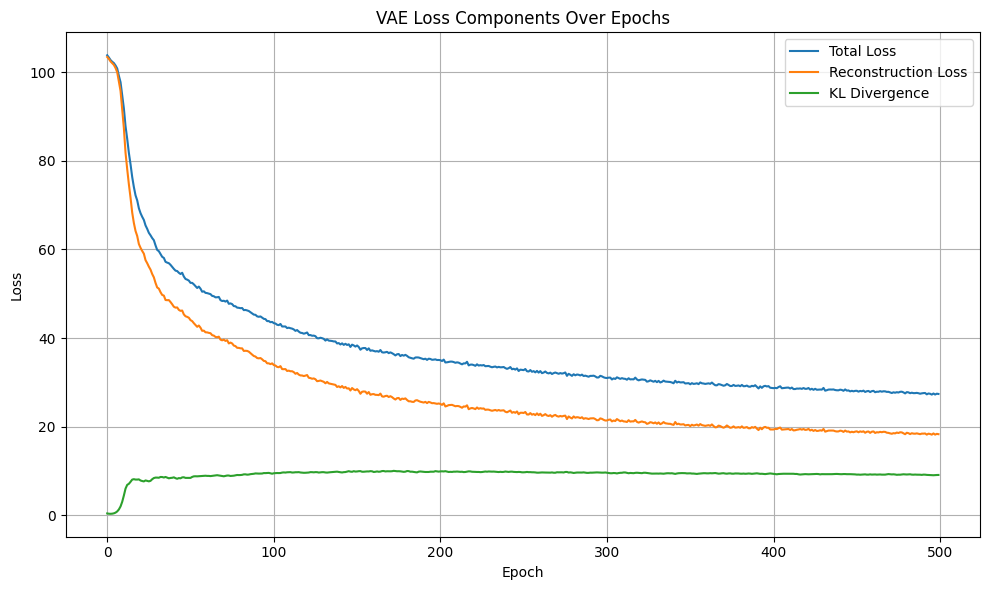

dim of latent mu: (331, 10)


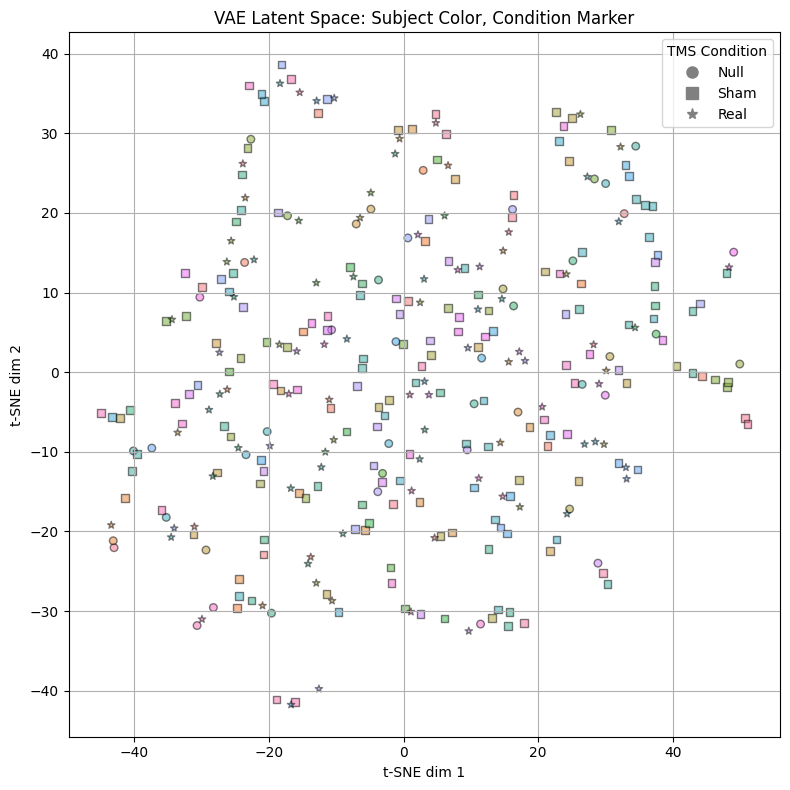

Paired t-test: t = -1.893, p = 0.0647


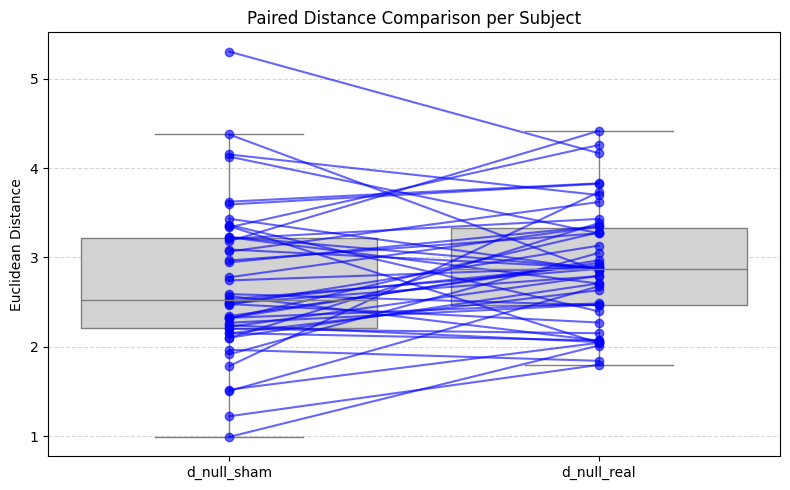

In [11]:
# Set up model, optimizer, and device
input_dim = X_tensor.shape[1]
cond_dim = subject_cond_tensor.shape[1]
latent_dim = 10
hidden_dim = 64 
NUM_EPOCH = 500
LR = 3e-4
model = CVAE(input_dim=input_dim, cond_dim=cond_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
total_loss_hist, recon_loss_hist, kld_loss_hist = train_vae(model, dataloader, optimizer, device=DEVICE, epochs=NUM_EPOCH)

plot_vae_losses(total_loss_hist, recon_loss_hist, kld_loss_hist)

mu_all = get_latent_mu_cvae(model, X_tensor, subject_cond_tensor, device=DEVICE)
# 2d-TSNE
z_2d = TSNE(n_components=2, perplexity=8).fit_transform(mu_all)
plot_latent_embedding_by_condition_and_subject(z_2d, all_tms_type, all_subject_id)

df = compute_condition_distances(mu_all, all_tms_type, all_subject_id, condition_map)

# Paired t-test
t_stat, p_val_t = ttest_rel(df["d_null_sham"], df["d_null_real"])
print(f"Paired t-test: t = {t_stat:.3f}, p = {p_val_t:.4f}")
plot_subject_distance_comparison(df)

In [ ]:
output_dir = project_root / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)   # ensure folder exists

# Build the filename
output_filename = output_dir / f"dist_summary_roi_{use_roi}.csv"

# Save DataFrame
df.to_csv(output_filename, index=False)

df_session_dists = compute_per_session_dist_to_null(mu_all, all_subject_id, all_tms_type, all_session)
output_filename = output_dir / f"session_distances_roi_{use_roi}.csv"

# Save DataFrame
df_session_dists.to_csv(output_filename, index=False)

<>:13: SyntaxWarning: invalid escape sequence '\h'
<>:13: SyntaxWarning: invalid escape sequence '\h'
/var/folders/br/nr4k1vxj1_j7jxk17x7xr8n9g2q0k8/T/ipykernel_76825/3939244392.py:13: SyntaxWarning: invalid escape sequence '\h'
  """Return reconstructions \hat{X} in same order as X."""


Reconstruction MSE (S vs C): t = 2.086, p = 0.0425 (means S=0.1834, C=0.1717, n=48)
Reconstruction corr r (S vs C): t = -0.028, p = 0.9776 (means S=0.8463, C=0.8466, n=48)


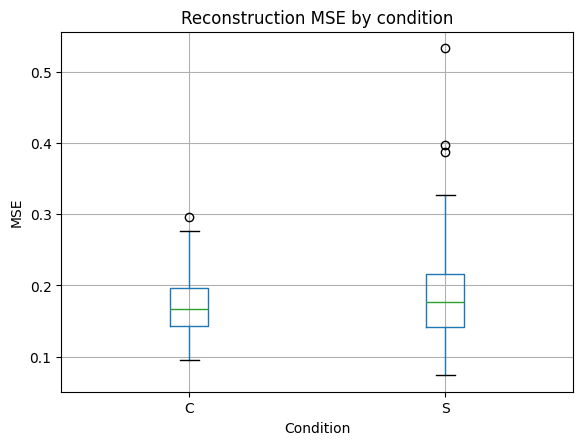

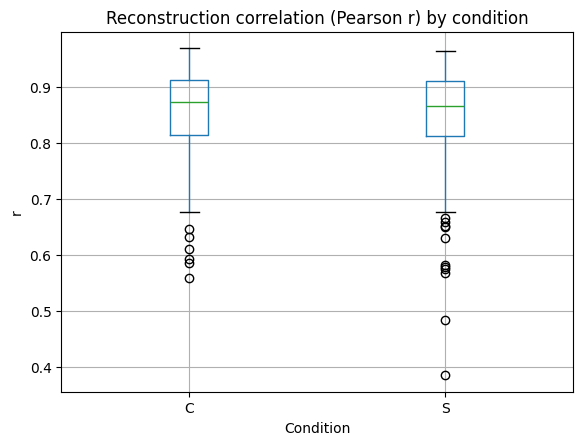

In [13]:
# ---------- Reconstruction fidelity by condition (per session) ----------
# Assumes: model is trained; X_tensor (N x D); subject_cond_tensor (N x cond_dim)
#          all_tms_type is an array-like of length N with 'S','C','N'
#          all_subject_id is array-like of subject IDs (ints/str)

import torch
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, ttest_rel
import matplotlib.pyplot as plt

def reconstruct_in_batches(model, X, C, batch_size=256, device=DEVICE):
    """Return reconstructions \hat{X} in same order as X."""
    model.eval()
    outs = []
    with torch.no_grad():
        for start in range(0, X.shape[0], batch_size):
            xb = X[start:start+batch_size].to(device)
            cb = C[start:start+batch_size].to(device)
            # forward pass; adapt to your model's API if different
            x_hat, mu, logvar = model(xb, cb)
            outs.append(x_hat.detach().cpu())
    return torch.cat(outs, dim=0)

def session_metrics(x_true, x_hat):
    """Return MSE and Pearson r for one session (1D tensors)."""
    # flatten to 1D
    a = x_true.view(-1).cpu().numpy()
    b = x_hat.view(-1).cpu().numpy()
    mse = np.mean((a - b)**2)
    # guard against constant vectors
    if np.std(a) == 0 or np.std(b) == 0:
        r = np.nan
    else:
        r = pearsonr(a, b)[0]
    return mse, r

# 1) Get reconstructions for all sessions
X_hat = reconstruct_in_batches(model, X_tensor, subject_cond_tensor, batch_size=512)

# 2) Compute per-session metrics
rows = []
for i in range(X_tensor.shape[0]):
    mse, r = session_metrics(X_tensor[i], X_hat[i])
    rows.append({
        "idx": i,
        "subject": str(all_subject_id[i]),
        "condition": str(all_tms_type[i]),   # 'S','C','N'
        "mse": float(mse),
        "r": float(r),
    })
recon_df = pd.DataFrame(rows)

# 3) Restrict to sham (S) and cTBS (C) for the reviewer’s comparison
sc = recon_df[recon_df["condition"].isin(["S","C"])].copy()

# 4) Aggregate within subject (mean over sessions per condition), then paired t-test
agg = sc.groupby(["subject","condition"], as_index=False)[["mse","r"]].mean()

wide_mse = agg.pivot(index="subject", columns="condition", values="mse").dropna()
wide_r   = agg.pivot(index="subject", columns="condition", values="r").dropna()

t_mse, p_mse = ttest_rel(wide_mse["S"], wide_mse["C"])
t_r,   p_r   = ttest_rel(wide_r["S"],   wide_r["C"])

print(f"Reconstruction MSE (S vs C): t = {t_mse:.3f}, p = {p_mse:.4f} "
      f"(means S={wide_mse['S'].mean():.4f}, C={wide_mse['C'].mean():.4f}, n={len(wide_mse)})")
print(f"Reconstruction corr r (S vs C): t = {t_r:.3f}, p = {p_r:.4f} "
      f"(means S={wide_r['S'].mean():.4f}, C={wide_r['C'].mean():.4f}, n={len(wide_r)})")

# 5) Quick visualization (boxplots) to drop in the manuscript/SI
fig, ax = plt.subplots()
sc.boxplot(column="mse", by="condition", ax=ax)
ax.set_title("Reconstruction MSE by condition")
ax.set_xlabel("Condition")
ax.set_ylabel("MSE")
plt.suptitle("")
plt.show()

fig, ax = plt.subplots()
sc.boxplot(column="r", by="condition", ax=ax)
ax.set_title("Reconstruction correlation (Pearson r) by condition")
ax.set_xlabel("Condition")
ax.set_ylabel("r")
plt.suptitle("")
plt.show()
